SoccerCPD

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
from scipy.spatial import Delaunay,distance_matrix
from scipy.spatial.distance import directed_hausdorff
import rpy2.robjects.packages as rpackages
from collections import Counter
import rpy2.rinterface_lib.embedded as rembedded
import rpy2.robjects as robjects
import ruptures as rpt
import os
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import multivariate_normal
from sklearn.metrics import pairwise_distances
from pprint import pprint
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)

In [2]:

print(pd.__version__)

2.2.3


In [3]:
#myconstants.py
# File paths and variable names
DIR_DATA = './data'
DIR_UGP_DATA = f'{DIR_DATA}/ugp'
DIR_TEMP_DATA = f'{DIR_DATA}/rtemp'

VARNAME_ACTIVITY_RECORDS = 'activity_records'
VARNAME_PLAYER_RECORDS = 'player_records'
VARNAME_PLAYER_PERIODS = 'player_periods'

# Column names and headers
LABEL_ID = 'id'
LABEL_NAME = 'name'
LABEL_VARNAME = 'varname'
LABEL_RECORDS = 'records'
LABEL_HEADER = 'header'
LABEL_DTYPES = 'dtypes'
LABEL_PATH = 'path'
LABEL_FILE = 'file'
LABEL_EXTENSION = 'extension'

LABEL_ACTIVITY_ID = 'activity_id'
LABEL_TEAM_ID = 'team_id'
LABEL_TYPE = 'type'
LABEL_DATE = 'date'
LABEL_TEAM_NAME = 'team_name'
LABEL_HOME_AWAY = 'home_away'
LABEL_ROTATED_SESSION = 'rotated_session'
LABEL_DATA_SAVED = 'data_saved'
LABEL_STATS_SAVED = 'stats_saved'
HEADER_ACTIVITY_RECORDS = [
    LABEL_ACTIVITY_ID, LABEL_TEAM_ID, LABEL_TYPE, LABEL_DATE, LABEL_TEAM_NAME,
    LABEL_HOME_AWAY, LABEL_ROTATED_SESSION, LABEL_DATA_SAVED, LABEL_STATS_SAVED
]

LABEL_PLAYER_ID = 'player_id'
LABEL_SQUAD_NUM = 'squad_num'
LABEL_PLAYER_NAME = 'player_name'
HEADER_ROSTER = [LABEL_PLAYER_ID, LABEL_SQUAD_NUM, LABEL_PLAYER_NAME]
HEADER_PLAYER_RECORDS = [LABEL_ACTIVITY_ID, LABEL_DATE, LABEL_TEAM_NAME] + HEADER_ROSTER

LABEL_PLAYER_PERIOD = 'player_period'
LABEL_SESSION = 'session'
LABEL_GAMETIME = 'gametime'
LABEL_START_DT = 'start_dt'
LABEL_END_DT = 'end_dt'
LABEL_DURATION = 'duration'
LABEL_PLAYER_IDS = 'player_ids'
HEADER_PLAYER_PERIODS = [
    LABEL_ACTIVITY_ID, LABEL_PLAYER_PERIOD, LABEL_TYPE, LABEL_SESSION, LABEL_GAMETIME,
    LABEL_START_DT, LABEL_END_DT, LABEL_DURATION, LABEL_PLAYER_IDS
]

LABEL_DATETIME = 'datetime'
LABEL_UNIXTIME = 'unixtime'
LABEL_X = 'x'
LABEL_Y = 'y'
LABEL_SPEED = 'speed'
HEADER_UGP = [
    LABEL_PLAYER_ID, LABEL_SESSION, LABEL_GAMETIME, LABEL_UNIXTIME,
    LABEL_PLAYER_PERIOD, LABEL_DURATION, LABEL_X, LABEL_Y, LABEL_SPEED
]

LABEL_INDEX = 'index'
LABEL_FORM_PERIOD = 'form_period'
LABEL_ROLE_PERIOD = 'role_period'
LABEL_START_TIME = 'start_time'
LABEL_END_TIME = 'end_time'
LABEL_X_NORM = 'x_norm'
LABEL_Y_NORM = 'y_norm'
LABEL_ROLE = 'role'
LABEL_BASE_ROLE = 'base_role'
LABEL_ALIGNED_ROLE = 'aligned_role'
LABEL_SWITCH_RATE = 'switch_rate'
HEADER_FGP = [
    LABEL_PLAYER_ID, LABEL_SESSION, LABEL_GAMETIME,
    LABEL_PLAYER_PERIOD, LABEL_FORM_PERIOD, LABEL_ROLE_PERIOD,
    LABEL_X, LABEL_Y, LABEL_X_NORM, LABEL_Y_NORM,
    LABEL_ROLE, LABEL_BASE_ROLE, LABEL_SWITCH_RATE
]

LABEL_COORDS = 'coords'
LABEL_EDGE_MAT = 'edge_mat'
LABEL_PERM = 'perm'
LABEL_BASE_PERM = 'base_perm'
LABEL_DISTN = 'distn'
LABEL_CLUSTER = 'cluster'
LABEL_FORMATION = 'formation'
HEADER_FORM_PERIODS = [
    LABEL_ACTIVITY_ID, LABEL_FORM_PERIOD, LABEL_SESSION,
    LABEL_START_DT, LABEL_END_DT, LABEL_DURATION, LABEL_COORDS, LABEL_EDGE_MAT
]
HEADER_ROLE_PERIODS = [
    LABEL_ACTIVITY_ID, LABEL_FORM_PERIOD, LABEL_ROLE_PERIOD, LABEL_SESSION, 
    LABEL_START_DT, LABEL_END_DT, LABEL_DURATION, LABEL_BASE_PERM
]
HEADER_ROLE_ALIGNS = [LABEL_ACTIVITY_ID, LABEL_FORM_PERIOD, LABEL_BASE_ROLE, LABEL_ALIGNED_ROLE, LABEL_X, LABEL_Y]
HEADER_ROLE_RECORDS = [
    LABEL_ACTIVITY_ID, LABEL_PLAYER_PERIOD, LABEL_FORM_PERIOD, LABEL_ROLE_PERIOD,
    LABEL_SESSION, LABEL_START_DT, LABEL_END_DT, LABEL_DURATION,
    LABEL_PLAYER_ID, LABEL_SQUAD_NUM, LABEL_PLAYER_NAME, LABEL_BASE_ROLE, LABEL_X, LABEL_Y
]

# Numeric constants
SCALAR_CENTI = 100
SCALAR_MILLI = 1000
SCALAR_MICRO = 1000000
SCALAR_TIME = 60

# Hyperparameters for SoccerCPD
MAX_SWITCH_RATE = 0.8
MAX_PVAL = 0.01 # the p-value must be less than  0.01,
MIN_PERIOD_DUR = 300 # segments must last at least 5 minutes = 60*5=300 seconds
MIN_FORM_DIST = 7  #The Manhattan distance between segment means must exceed 7.0.


In [4]:
# For convenient data loading and saving
class RecordManager:
    def __init__(self, root_dir=DIR_DATA):
        self.root_dir = root_dir
        self.activity_records = None
        self.player_records = None
        self.player_periods = None
        self.metadata = pd.DataFrame([
            [VARNAME_ACTIVITY_RECORDS, HEADER_ACTIVITY_RECORDS, '.csv'],
            [VARNAME_PLAYER_RECORDS, HEADER_PLAYER_RECORDS, '.csv'],
            [VARNAME_PLAYER_PERIODS, HEADER_PLAYER_PERIODS, '.pkl'],
        ], columns=[LABEL_VARNAME, LABEL_HEADER, LABEL_EXTENSION])
        self._load_records()

    def _load_records(self):
        for i in self.metadata.index:
            metadata = self.metadata.loc[i]
            path = f'{self.root_dir}/{metadata[LABEL_VARNAME]}{metadata[LABEL_EXTENSION]}'
            print(path)
            if not os.path.exists(path):
                if metadata[LABEL_HEADER] is None:
                    records = dict()
                else:
                    records = pd.DataFrame(columns=metadata[LABEL_HEADER])
            elif metadata[LABEL_EXTENSION] == '.csv':
                try:
                    records = pd.read_csv(path, header=0, encoding='utf-8-sig')
                except UnicodeDecodeError:
                    records = pd.read_csv(path, header=0, encoding='cp949')
            else:
                records = pd.read_pickle(path)
            setattr(self, metadata[LABEL_VARNAME], records[metadata[LABEL_HEADER]])

    def save_records(self, attr=VARNAME_ACTIVITY_RECORDS):
        metadata = self.metadata[self.metadata[LABEL_VARNAME] == attr].iloc[0]
        records = getattr(self, attr)
        path = f'{self.root_dir}/{metadata[LABEL_VARNAME]}{metadata[LABEL_EXTENSION]}'
        if metadata[LABEL_EXTENSION] == '.csv':
            records.to_csv(path, index=False, encoding='utf-8-sig')
            print(f"'{path}' saving done.")
        elif metadata[LABEL_EXTENSION] == '.pkl':
            records.to_pickle(path)

    def load_activity_data(self, activity_id):
        activity_record = self.activity_records[self.activity_records[LABEL_ACTIVITY_ID] == activity_id].iloc[0]
        player_periods = self.player_periods[self.player_periods[LABEL_ACTIVITY_ID] == activity_id]
        player_periods = player_periods.set_index(LABEL_PLAYER_PERIOD)[HEADER_PLAYER_PERIODS[2:]]
        player_records = self.player_records[self.player_records[LABEL_ACTIVITY_ID] == activity_id]
        roster = player_records[HEADER_ROSTER].drop_duplicates().set_index(LABEL_PLAYER_ID)
        ugp_df = pd.read_pickle(f'{DIR_UGP_DATA}/{activity_id}.ugp')
        return activity_record, player_periods, roster, ugp_df


In [5]:
pd.options.mode.chained_assignment = None


# For match data preprocessing
class Match:
    def __init__(self, activity_record, player_periods, roster, ugp, pitch_size=(10800, 7200), outliers=None):
        self.record = activity_record
        self.player_periods = player_periods
        self.ugp = ugp
        self.roster = self._upgrade_roster(roster, outliers)
        self.pitch_size = pitch_size

    # Synchronize the player movement data with the official roster
    def _upgrade_roster(self, roster, outliers=None):
        if outliers is not None:
            self.ugp = self.ugp[~self.ugp[LABEL_PLAYER_ID].isin(outliers)]
            for period in self.player_periods.index:
                player_ids = self.player_periods.at[period, LABEL_PLAYER_IDS]
                self.player_periods.at[period, LABEL_PLAYER_IDS] = list(set(player_ids) - set(outliers))

        player_ids = []
        for player_id in roster.index:
            if not self.ugp[self.ugp[LABEL_PLAYER_ID] == player_id].empty:
                player_ids.append(player_id)
            if player_id not in self.player_periods.at[0, LABEL_PLAYER_IDS]:
                # Change 'player_name' to 0 for the player not in the official roster,
                # so that it can be filtered to be manually checked
                roster.at[player_id, LABEL_PLAYER_NAME] = 0
        roster = roster.loc[player_ids]

        if len(self.player_periods) > 1:
            for period in self.player_periods.index[1:]:
                roster[period] = 0
                for player_id in roster.index:
                    if player_id in self.player_periods.at[period, LABEL_PLAYER_IDS]:
                        roster.at[player_id, period] = 1
            return roster.sort_values(by=[1, LABEL_SQUAD_NUM], ascending=[False, True]).reset_index()
        else:
            return roster.sort_values(LABEL_SQUAD_NUM).reset_index()

    # Compute relative elapsed time in a session from unixtime
    @staticmethod
    def _compute_gametime(current_ut, start_ut):
        seconds_total = current_ut - start_ut
        minutes = int(seconds_total / SCALAR_TIME)
        seconds_rest = seconds_total % SCALAR_TIME
        return "{0:02d}:{1:04.1f}".format(minutes, seconds_rest)

    # Filter in-play data from the measured data using the start, end, and substitution records
    def construct_inplay_ugp(self):
        
        freq = f"{self.ugp[LABEL_DURATION].iloc[1].round(1)}s"
        ugp_inplay = []

        for i in self.roster.index:
            # If a player in the official roster didn't actually played,
            # then exclude his/her entire data from the analysis
            if self.roster.at[i, LABEL_PLAYER_NAME] != 0 and self.roster.iloc[i, len(HEADER_ROSTER) :].sum() == 0:
                continue

            player_id = self.roster.at[i, LABEL_PLAYER_ID]
            try:
                player_ugp = self.ugp[self.ugp[LABEL_PLAYER_ID] == player_id]
            except IndexError:
                continue
            else:
                player_ugp_inplay = []
                session_start_ut = 0
                for j in self.player_periods.index[1:]:
                    player_period = self.player_periods.loc[j]
                    start_dt = player_period[LABEL_START_DT]
                    end_dt = player_period[LABEL_END_DT]
                    dt_idx = pd.DataFrame(index=pd.date_range(start_dt, end_dt, freq=freq))[1:]
                    period_ugp = pd.merge(player_ugp, dt_idx, how="right", left_index=True, right_index=True)
                    period_ugp[LABEL_PLAYER_PERIOD] = j
                    period_ugp[LABEL_SESSION] = player_period[LABEL_SESSION]

                    if player_period[LABEL_TYPE].startswith("START"):
                        session_start_ut = (start_dt - datetime(1970, 1, 1)).total_seconds()
                    period_ugp[LABEL_UNIXTIME] = period_ugp.index.view(np.int64) // SCALAR_MICRO / SCALAR_MILLI
                    period_ugp[LABEL_GAMETIME] = period_ugp[LABEL_UNIXTIME].apply(
                        lambda x: self._compute_gametime(x, session_start_ut)
                    )
                    period_ugp[LABEL_DURATION] = float(freq[:-1])

                    # Remove the player's period data if he/she didn't actually play in that period,
                    # except for the players not in the official roster (to manually check the validity)
                    if (
                        player_id in self.player_periods.at[0, LABEL_PLAYER_IDS]
                        and player_id not in self.player_periods.at[j, LABEL_PLAYER_IDS]
                    ):
                        period_ugp[HEADER_UGP[5:]] = np.nan
                    player_ugp_inplay.append(period_ugp[HEADER_UGP])

                player_ugp_inplay = pd.concat(player_ugp_inplay)
                player_ugp_inplay[LABEL_PLAYER_ID] = int(player_id)
                ugp_inplay.append(player_ugp_inplay)

        self.ugp = pd.concat(ugp_inplay)

    # Rotate the pitch for one of the sessions so that the team always attacks from left to right
    def rotate_pitch(self):
        xlim = self.pitch_size[0]
        ylim = self.pitch_size[1]
        rotated = 2 - self.record[LABEL_ROTATED_SESSION]
        for session in self.player_periods[LABEL_SESSION].unique()[1:]:
            # If rotated == 0, rotate the even-numbered sessions (sessions with session % 2 == 0)
            # If rotated == 1, rotate the odd-numbered sessions (sessions with session % 2 == 1)
            if session % 2 == rotated:
                session_idx = self.ugp[LABEL_SESSION] == session
                self.ugp.loc[session_idx, LABEL_X] = xlim - self.ugp[LABEL_X].loc[session_idx]
                self.ugp.loc[session_idx, LABEL_Y] = ylim - self.ugp[LABEL_Y].loc[session_idx]


In [6]:

pd.set_option("display.width", 250)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)


# Frame-by-frame role assignment proposed by Bialkowski et al. (2014)
class RoleRep:
    def __init__(self, ugp_):
        self.ugp = ugp_
        self.fgp = None
        self.role_distns = None

    @staticmethod
    def normalize_locs(moment_fgp):
        locs = moment_fgp[[LABEL_X, LABEL_Y]]
        moment_fgp[[LABEL_X_NORM, LABEL_Y_NORM]] = locs - locs.mean()
        return moment_fgp

    @staticmethod
    def generate_fgp(ugp, freq):
        ugp = ugp[ugp[LABEL_X].notna()]
        fgp = []
        role = 1

        for player_id in ugp[LABEL_PLAYER_ID].unique():
            player_ugp = ugp[ugp[LABEL_PLAYER_ID] == player_id]
            resampler = player_ugp.resample(freq, closed="right", label="right")
            player_fgp = resampler[HEADER_FGP[:4]].last()
            player_fgp[LABEL_X] = resampler[LABEL_X].mean().round()
            player_fgp[LABEL_Y] = resampler[LABEL_Y].mean().round()
            player_fgp[LABEL_X_NORM] = np.nan
            player_fgp[LABEL_Y_NORM] = np.nan
            player_fgp[LABEL_FORM_PERIOD] = resampler[LABEL_FORM_PERIOD].last()
            player_fgp[LABEL_ROLE_PERIOD] = resampler[LABEL_ROLE_PERIOD].last()
            player_fgp[LABEL_ROLE] = role
            player_fgp[LABEL_BASE_ROLE] = role
            player_fgp[LABEL_SWITCH_RATE] = 0
            fgp.append(player_fgp[HEADER_FGP])
            role += 1

        fgp = pd.concat(fgp).reset_index().rename(columns={LABEL_INDEX: LABEL_DATETIME})
        return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)

    @staticmethod
    def estimate_mvn(df, col_x=LABEL_X_NORM, col_y=LABEL_Y_NORM, filter=True):
        if filter:
            coords = df[df[LABEL_SWITCH_RATE] <= MAX_SWITCH_RATE][[col_x, col_y]]
        else:
            coords = df[[col_x, col_y]]

        if filter and len(coords) < 30:
            return np.nan
        else:
            return multivariate_normal(coords.mean(), coords.cov())

    @staticmethod
    def update_params(fgp, by_phase=False):
        cols = [LABEL_PLAYER_PERIOD, LABEL_ROLE] if by_phase else [LABEL_ROLE]
        role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()
        return role_distns.dropna().rename(columns={0: LABEL_DISTN})

    @staticmethod
    def align_formations(fgp, role_distns, label_group=LABEL_SESSION):
        groups = fgp[label_group].unique()
        base_group = groups[role_distns.groupby(label_group)[LABEL_ROLE].count().argmax()]
        base_role_distns = role_distns[role_distns[label_group] == base_group]

        for group in groups:
            if group == base_group:
                continue
            group_role_distns = role_distns[role_distns[label_group] == group]
            cost_mat = distance_matrix(
                group_role_distns[LABEL_DISTN].apply(lambda x: pd.Series(x.mean)).values,
                base_role_distns[LABEL_DISTN].apply(lambda x: pd.Series(x.mean)).values,
            )
            row_idx, col_idx = linear_sum_assignment(cost_mat)
            role_dict = dict(
                zip(group_role_distns[LABEL_ROLE].iloc[row_idx], base_role_distns[LABEL_ROLE].iloc[col_idx])
            )
            role_dict[0] = 0
            role_distns.loc[role_distns[label_group] == group, LABEL_ROLE] = col_idx + 1
            fgp.loc[fgp[label_group] == group, LABEL_ROLE] = fgp.loc[fgp[label_group] == group, LABEL_ROLE].apply(
                lambda role: role_dict[role]
            )
            fgp.loc[fgp[label_group] == group, LABEL_BASE_ROLE] = fgp.loc[
                fgp[label_group] == group, LABEL_BASE_ROLE
            ].apply(lambda role: role_dict[role])

        return fgp, role_distns.sort_values(by=[label_group, LABEL_ROLE]).reset_index(drop=True)

    def hungarian(self, moment_fgp, role_distns):
        cost_mat = moment_fgp[moment_fgp.columns[(len(HEADER_FGP) + 1) :]].values
        row_idx, col_idx = linear_sum_assignment(cost_mat)
        base_roles = moment_fgp[LABEL_BASE_ROLE].iloc[row_idx].values
        temp_roles = role_distns[LABEL_ROLE].iloc[col_idx].values
        self.fgp.loc[moment_fgp.index, LABEL_ROLE] = temp_roles
        self.fgp.loc[moment_fgp.index, LABEL_SWITCH_RATE] = (base_roles != temp_roles).sum() / len(row_idx)
        return cost_mat[row_idx, col_idx].mean()

    def run(self, freq="1s", verbose=True):
        temp_fgp = self.ugp.groupby(LABEL_PLAYER_PERIOD).apply(RoleRep.generate_fgp, freq=freq)
        temp_fgp = temp_fgp.reset_index(drop=True).dropna()
        temp_role_distns = RoleRep.update_params(temp_fgp, by_phase=True)
        temp_fgp = pd.merge(temp_fgp, temp_role_distns[[LABEL_PLAYER_PERIOD, LABEL_ROLE]])
        self.fgp, _ = RoleRep.align_formations(temp_fgp, temp_role_distns, LABEL_PLAYER_PERIOD)
        self.role_distns = RoleRep.update_params(self.fgp)

        max_iter = 10
        cost_prev = float("inf")
        tol = 0.005
        self.fgp.reset_index(drop=True, inplace=True)

        for i_iter in range(max_iter):
            cost_df = pd.DataFrame(
                self.role_distns[LABEL_DISTN]
                .apply(lambda n: pd.Series(-np.log(n.pdf(self.fgp[[LABEL_X_NORM, LABEL_Y_NORM]]))))
                .transpose()
                .values,
                index=self.fgp.index,
            )
            fgp_cost_df = pd.concat([self.fgp, cost_df], axis=1)
            costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
            cost_new = costs.mean()
            if verbose:
                print("- Cost after iteration {0}: {1:.3f}".format(i_iter + 1, cost_new))
            self.role_distns = RoleRep.update_params(self.fgp)
            if cost_new + tol > cost_prev:
                if verbose:
                    print("Iteration finished since there are no significant changes.")
                    break
            cost_prev = cost_new

        session = self.ugp[LABEL_SESSION].iloc[0]
        self.role_distns[LABEL_SESSION] = session

        return self.fgp




In [7]:


pd.set_option("display.width", 250)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)


# Formation and role change-point detection (main algorithm)
class SoccerCPD:
    def __init__(
        self,
        match,
        apply_cpd=True,
        formcpd_type="gseg_avg",
        rolecpd_type="gseg_avg",
        max_sr=MAX_SWITCH_RATE,
        max_pval=MAX_PVAL,
        min_pdur=MIN_PERIOD_DUR,
        min_fdist=MIN_FORM_DIST,
        
    ):
        self.apply_cpd = apply_cpd
        self.formcpd_type = formcpd_type
        self.rolecpd_type = rolecpd_type
        # Available FormCPD types: 'gseg_avg', 'gseg_union', 'kernel_linear', 'kernel_rbf', 'kernel_cosine', 'rank'
        # Available RoleCPD types: 'gseg_avg', 'gseg_union'

        self.max_sr = max_sr
        self.max_pval = max_pval
        self.min_pdur = min_pdur
        self.min_fdist = min_fdist

        self.match = match
        self.activity_id = self.match.record[LABEL_ACTIVITY_ID]
        self.player_periods = self.match.player_periods
        self.ugp = self.match.ugp

        self.fgp = pd.DataFrame(columns=[LABEL_DATETIME] + HEADER_FGP)
        self.form_periods = pd.DataFrame(columns=HEADER_FORM_PERIODS)
        self.role_periods = pd.DataFrame(columns=HEADER_ROLE_PERIODS)
        self.role_records = None

        self.target_dir = f"{DIR_DATA}/{formcpd_type}" if apply_cpd else f"{DIR_DATA}/noncpd"

    # Apply Delaunay triangulation to the given player coordinates to obtain the role-adjacency matrix
    @staticmethod
    def delaunay_edge_mat(coords):
        tri_pts = Delaunay(coords).simplices
        edges = np.concatenate((tri_pts[:, :2], tri_pts[:, 1:], tri_pts[:, ::2]), axis=0)
        edge_mat = np.zeros((coords.shape[0], coords.shape[0]))
        edge_mat[edges[:, 0], edges[:, 1]] = 1
        return np.clip(edge_mat + edge_mat.T, 0, 1)

    @staticmethod
    def complete_perm(perm, role_set):
        if perm.isnull().sum():
            return perm.fillna(list(role_set - set(perm.dropna()))[0])
        else:
            return perm

    @staticmethod
    def hamming(perm1, perm2):
        return (perm1 != perm2).astype(int).sum()

    @staticmethod
    def manhattan(mat1, mat2):
        return np.abs(mat1 - mat2).sum()
    
    @staticmethod 
    def distL2(mat1,mat2):
        return np.linalg.norm(mat1-mat2)

    # Recursive change-point detection for the input sequence
    def detect_change_times(self, input_seq, sub_dts, mode="form"):
        # if mode == 'form' (FormCPD), the input is a sequence of role-adjacency matrices
        # if mode == 'role' (RoleCPD), the input a sequence of role permutations

        start_time = input_seq.index[0].time()
        end_time = input_seq.index[-1].time()

        if (mode == "role") or ("gseg" in self.formcpd_type):
            metric = SoccerCPD.manhattan if mode == "form" else SoccerCPD.hamming
            dists = pd.DataFrame(pairwise_distances(input_seq.drop_duplicates(), metric=metric))

            # Save the input sequence and the pairwise distances so that we can use them in the R script below
            if not os.path.exists(DIR_TEMP_DATA):
                os.mkdir(DIR_TEMP_DATA)
            input_seq.to_csv(f"{DIR_TEMP_DATA}/{self.activity_id}_temp_seq.csv", index=False)
            dists.to_csv(f"{DIR_TEMP_DATA}/{self.activity_id}_temp_dists.csv", index=False)

            try:
                print(f"Applying g-segmentation to the sequence between {start_time} and {end_time}...")

                if mode == "form":
                    gseg_type = self.formcpd_type.split("_")[1][0]
                else:
                    gseg_type = self.rolecpd_type.split("_")[1][0]

                # Run the R function 'gseg1_discrete' to find a change-point
                # rpackages.importr('gSeg', lib_loc=rpackages.importr('base')._libPaths()[0])
                robjects.r(
                    f"""
                    dir = '{DIR_TEMP_DATA}'
                    seq_path = paste(dir, '{self.activity_id}_temp_seq.csv', sep='/')
                    seq = read.csv(seq_path)
                    dists_path = paste(dir, '{self.activity_id}_temp_dists.csv', sep='/')
                    dists = read.csv(dists_path)
                    n = dim(seq)[1]
                    edge_mat = nnl(dists, 1)
                    seq_str = do.call(paste, seq)
                    ids = match(seq_str, unique(seq_str))
                    output = gseg1_discrete(n, edge_mat, ids, statistics='generalized', n0=0.1*n, n1=0.9*n)
                    chg_idx = output$scanZ$generalized$tauhat_{gseg_type}
                    pval = output$pval.appr$generalized_{gseg_type}
                    """
                )

            except rembedded.RRuntimeError:
                return []

            # Check whether the detected change-point is significant, using the following three conditions
            # Condition (1): The p-value of the scan statistic must be less than 0.1
            if robjects.r["pval"][0] >= self.max_pval:
                print("Change-point insignificant: The p-value is not small enough.\n")
                return []
            else:
                chg_idx = robjects.r["chg_idx"][0]

        elif "kernel" in self.formcpd_type:
            print(f"Applying kernel-based CPD to the sequence between {start_time} and {end_time}...")
            kernel_type = self.formcpd_type.split("_")[1]
            algo = rpt.Binseg(model=kernel_type).fit(input_seq.values)
            chg_idx = algo.predict(n_bkps=1)[0]

        elif "rank" in self.formcpd_type:
            print(f"Applying rank-based CPD to the sequence between {start_time} and {end_time}...")
            algo = rpt.Binseg(model="rank").fit(input_seq.values)
            chg_idx = algo.predict(n_bkps=1)[0]

        else:
            raise ValueError("Invalid formcpd_type.")

        chg_dt = input_seq.index[chg_idx]

        # Fine-tune chg_dt to the closest substitution time (if exists)
        if len(sub_dts) > 0:
            tds = np.abs(sub_dts - chg_dt.to_pydatetime())
            if tds.min().total_seconds() <= 180:
                chg_dt = sub_dts[tds.argmin()]

        # Condition (2): Both of the segments must last for at least five minutes
        seq1 = input_seq[:chg_dt]
        seq2 = input_seq[chg_dt:]
        if (len(seq1) < self.min_pdur) or (len(seq2) < self.min_pdur):
            print("Change-point insignificant: One of the periods has not enough duration.\n")
            return []

        if mode == "form":
            # Condition (3) for FormCPD: The respective mean role-adjacency matrices
            # from the segments before and after chg_dt are far enough from each other
            form1_edge_mat = seq1.mean(axis=0).values
            form2_edge_mat = seq2.mean(axis=0).values
            if self.manhattan(form1_edge_mat, form2_edge_mat) < self.min_fdist:
                print("Change-point insignificant: The formation is not changed.\n")
                return []
            else:
                # If significant, recursively detect another change-points before and after chg_dt
                print(f"A significant fine-tuned change-point at {chg_dt.time()}.\n")
                prev_chg_dts = self.detect_change_times(seq1, sub_dts)
                next_chg_dts = self.detect_change_times(seq2, sub_dts)
                return prev_chg_dts + [chg_dt] + next_chg_dts

        elif mode == "role":
            # Condition (3) for RoleCPD: The most frequent permutations differ between before and after chg_dt
            seq1_str = seq1.apply(lambda row: np.array2string(row.values), axis=1)
            seq2_str = seq2.apply(lambda row: np.array2string(row.values), axis=1)
            counter1 = Counter(seq1_str)
            counter2 = Counter(seq2_str)
            if counter1.most_common(1)[0][0] == counter2.most_common(1)[0][0]:
                print("Change-point insignificant: The most frequent permutation is not changed.\n")
                return []
            else:
                # If significant, recursively detect another change-points before and after chg_dt
                print(f"A significant fine-tuned change-point at {chg_dt.time()}.")
                print(f"- Frequent permutations before {chg_dt.time()}:")
                pprint(counter1.most_common(5))
                print(f"- Frequent permutations after {chg_dt.time()}:")
                pprint(counter2.most_common(5))
                print()
                prev_chg_dts = self.detect_change_times(seq1, sub_dts)
                next_chg_dts = self.detect_change_times(seq2, sub_dts)
                return prev_chg_dts + [chg_dt] + next_chg_dts

        else:
            raise ValueError("Invalid mode")

    # Align corresponding roles from different formation periods
    @staticmethod
    def align_formations(fgp, form_period_records):
        base_form_period_record = form_period_records.iloc[0]

        for form_period in form_period_records.index[1:]:
            cur_form_period_record = form_period_records.loc[form_period]
            cost_mat = distance_matrix(
                base_form_period_record[LABEL_COORDS],
                cur_form_period_record[LABEL_COORDS],
            )
            _, perm = linear_sum_assignment(cost_mat)
            form_period_records.at[form_period, LABEL_COORDS] = cur_form_period_record[LABEL_COORDS][perm]
            form_period_records.at[form_period, LABEL_EDGE_MAT] = cur_form_period_record[LABEL_EDGE_MAT][perm][:, perm]

            inverse_perm = dict(zip(np.array(perm) + 1, np.arange(10) + 1))
            cur_fgp = fgp[fgp[LABEL_FORM_PERIOD] == form_period]
            for col in [LABEL_ROLE, LABEL_BASE_ROLE]:
                fgp.loc[cur_fgp.index, col] = cur_fgp[col].apply(lambda role: inverse_perm[role])

        return fgp, form_period_records

    @staticmethod
    def most_common(player_roles):
        try:
            counter = Counter(player_roles[player_roles.notna()])
            return counter.most_common(1)[0][0]
        except IndexError:
            return np.nan

    def reassign_base_role(self, fgp_row):
        base_perm = self.role_periods.at[fgp_row[LABEL_ROLE_PERIOD], LABEL_BASE_PERM]
        fgp_row[LABEL_BASE_ROLE] = base_perm[fgp_row[LABEL_BASE_ROLE]]
        return fgp_row

    # Recompute the 'switch rate' of a frame by the Hamming distance
    # between the temporary roles and the instructed roles
    @staticmethod
    def recompute_switch_rate(moment_fgp):
        hamming = SoccerCPD.hamming(moment_fgp[LABEL_ROLE], moment_fgp[LABEL_BASE_ROLE])
        moment_fgp[LABEL_SWITCH_RATE] = hamming / len(moment_fgp)
        return moment_fgp

    # Refind base roles per player period and recompute switch rate per frame for the precomputed FGP data
    def reset_precomputed_fgp(self):
        for i in self.player_periods.index[1:]:
            fgp = self.fgp[self.fgp[LABEL_PLAYER_PERIOD] == i]
            perms = fgp.pivot_table(LABEL_ROLE, LABEL_DATETIME, LABEL_PLAYER_ID, "first")
            if perms.empty:
                continue
            # role_set = set(perms.dropna().iloc[0])
            role_set = set(np.arange(10) + 1)
            perms = perms.apply(SoccerCPD.complete_perm, axis=1, args=(role_set,)).astype(int)
            perms_str = perms.apply(lambda perm: np.array2string(perm.values), axis=1)
            base_perm_list = np.fromstring(SoccerCPD.most_common(perms_str)[1:-1], dtype="float32", sep=" ")
            base_perm_dict = dict(zip(perms.columns, base_perm_list))
            self.fgp.loc[fgp.index, LABEL_BASE_ROLE] = fgp[LABEL_PLAYER_ID].apply(lambda x: base_perm_dict[x])
        self.fgp = self.fgp.groupby(LABEL_DATETIME, group_keys=False).apply(SoccerCPD.recompute_switch_rate)

    def generate_role_records(self):
        grouped = self.fgp.groupby([LABEL_PLAYER_ID, LABEL_ROLE_PERIOD], group_keys=False, as_index=False)
        role_records = grouped[[LABEL_PLAYER_PERIOD, LABEL_BASE_ROLE]].first()
        role_records = pd.merge(role_records, self.role_periods[HEADER_ROLE_PERIODS[:-1]])

        role_records = pd.merge(role_records, self.form_periods[[LABEL_FORM_PERIOD, LABEL_COORDS]])
        role_records[LABEL_X] = role_records.apply(lambda x: x[LABEL_COORDS][x[LABEL_BASE_ROLE] - 1, 0], axis=1)
        role_records[LABEL_Y] = role_records.apply(lambda x: x[LABEL_COORDS][x[LABEL_BASE_ROLE] - 1, 1], axis=1)

        role_records = pd.merge(role_records, self.match.roster[HEADER_ROSTER])
        return role_records[HEADER_ROLE_RECORDS].astype({LABEL_PLAYER_PERIOD: int})

    def run(self, use_precomputed_fgp=True, freq="1s"):
        fgp_path = f"data/{self.formcpd_type}/fgp/{self.activity_id}.csv"
        form_periods = []
        role_periods = []

        # If self.use_precomputed_fgp == True, load and initialize the precomputed FGP data
        if use_precomputed_fgp and os.path.exists(fgp_path):
            self.fgp = pd.read_csv(fgp_path, header=0, encoding="utf-8-sig")
            self.fgp[LABEL_DATETIME] = self.fgp[LABEL_DATETIME].apply(
                lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
            )
            self.reset_precomputed_fgp()

        # Initialize formation and role period labels by the session labels
        self.ugp[LABEL_FORM_PERIOD] = self.ugp[LABEL_SESSION]
        self.ugp[LABEL_ROLE_PERIOD] = self.ugp[LABEL_SESSION]

        fgp_list = []
        perm_list = []

        for session in self.ugp[LABEL_SESSION].unique():
            print(f"\n{'-' * 33} Session {session} {'-' * 34}")
            player_periods = self.player_periods[self.player_periods[LABEL_SESSION] == session]
            session_start_dt = pd.to_datetime(player_periods[LABEL_START_DT].iloc[0])
            session_end_dt = pd.to_datetime(player_periods[LABEL_END_DT].iloc[-1])
            session_ugp = self.ugp[self.ugp[LABEL_SESSION] == session]

            grouper = session_ugp.dropna(subset="x").groupby("gametime", group_keys=False)
            if grouper["player_id"].apply(len).max() < 10:
                # If less than 10 players have been measured during the session, skip the process
                print("Not enough players to estimate a formation.")
                continue
            else:
                print(player_periods[HEADER_PLAYER_PERIODS[2:7]])

            if use_precomputed_fgp and not self.fgp.empty:
                print("\n* Step 1: Load the pre-computed role assignment result")
                fgp = self.fgp[self.fgp[LABEL_SESSION] == session]
                print(f"Session FGP data loaded and filtered from '{fgp_path}'.")
            else:
                print("\n* Step 1: Frame-by-frame role assignment using RoleRep")
                rolerep = RoleRep(session_ugp)
                fgp = rolerep.run(freq=freq)

            # Exclude situations such as set-pieces that are irrelevant to the team formation
            valid_fgp = fgp[fgp[LABEL_SWITCH_RATE] <= self.max_sr]

            # Check whether all the 10 outfield players are measured for some periods
            role_x = valid_fgp.pivot_table(LABEL_X_NORM, LABEL_DATETIME, LABEL_ROLE, aggfunc="first")
            role_y = valid_fgp.pivot_table(LABEL_Y_NORM, LABEL_DATETIME, LABEL_ROLE, aggfunc="first")
            role_coords = np.dstack([role_x.dropna().values, role_y.dropna().values])
            if role_coords.shape[1] < 10:
                print("Not enough players to estimate a formation.")
                continue
            else:
                fgp_list.append(fgp)

            # Generate the sequence of role-adjacency matrices
            edge_mats = []
            for coords in role_coords:
                edge_mats.append(SoccerCPD.delaunay_edge_mat(coords).reshape(-1))
            edge_mats = pd.DataFrame(np.stack(edge_mats, axis=0), index=role_x.dropna().index)

            if self.apply_cpd:
                print("\n* Step 2: FormCPD based on role-adjacency matrices")
                # Recursive change-point detection for the matrix sequence
                sub_dts = pd.to_datetime(
                    player_periods.loc[player_periods[LABEL_TYPE].isin(["SUB", "RED"]), LABEL_START_DT].values
                )
                form_chg_dts = self.detect_change_times(edge_mats, sub_dts, mode="form")

                print("Detected formation change-points (rounded off to the nearest 10 second mark):")
                form_chg_dts_rounded = []
                for dt in form_chg_dts:
                    form_chg_dts_rounded.append(dt - timedelta(seconds=dt.second % 10))
                pprint(form_chg_dts_rounded)

                print("\n* Step 3: RoleCPD per formation period based on role permutations")
                form_chg_dts = [session_start_dt] + form_chg_dts_rounded + [session_end_dt]

            else:
                print("\n* Step 2: Compute the formation graph of the session")
                # Assume there are no formation change throughout the session
                form_chg_dts = [session_start_dt, session_end_dt]

                print("\n* Step 3: Find the most frequent role permutation per 5-minute segment")

            # Generate the sequence of role permutations
            perms = valid_fgp.pivot_table(LABEL_BASE_ROLE, LABEL_DATETIME, LABEL_ROLE, aggfunc="first")
            role_set = set(perms.dropna().iloc[0])
            perms = perms.apply(SoccerCPD.complete_perm, axis=1, args=(role_set,)).astype(int)
            perms_str = perms.apply(lambda perm: np.array2string(perm.values), axis=1)
            perm_list.append(perms_str.rename(LABEL_PERM).to_frame())

            for form_chg_idx in range(1, len(form_chg_dts)):
                form_period = len(form_periods) + 1
                form_start_dt = form_chg_dts[form_chg_idx - 1]
                form_end_dt = form_chg_dts[form_chg_idx]

                mean_x = role_x[form_start_dt:form_end_dt].dropna().mean(axis=0).round().values
                mean_y = role_y[form_start_dt:form_end_dt].dropna().mean(axis=0).round().values
                mean_coords = np.stack([mean_x, mean_y]).T
                mean_edge_mat = edge_mats[form_start_dt:form_end_dt].mean(axis=0).round(3).values

                # Recording the details of the formation period
                form_periods.append(
                    {
                        LABEL_ACTIVITY_ID: self.activity_id,
                        LABEL_SESSION: session,
                        LABEL_FORM_PERIOD: form_period,
                        LABEL_START_DT: form_start_dt,
                        LABEL_END_DT: form_end_dt,
                        LABEL_DURATION: (form_end_dt - form_start_dt).total_seconds(),
                        LABEL_COORDS: mean_coords,
                        LABEL_EDGE_MAT: mean_edge_mat.reshape(10, 10),
                    }
                )

                if self.apply_cpd:
                    # Recursive change-point detection for the permutation sequence
                    print(f"\nRoleCPD for the formation period {form_period}:")
                    input_perms = perms[form_start_dt:form_end_dt]
                    input_sub_dts = np.array([dt for dt in sub_dts if (dt >= form_start_dt) and (dt < form_end_dt)])
                    role_chg_dts = self.detect_change_times(input_perms, input_sub_dts, mode="role")

                    print("Detected role change-points (rounded off to the nearset 10 second mark):")
                    role_chg_dts_rounded = []
                    for dt in role_chg_dts:
                        role_chg_dts_rounded.append(dt - timedelta(seconds=dt.second % 10))
                    pprint(role_chg_dts_rounded)

                    role_chg_dts = [form_start_dt, form_end_dt] + input_sub_dts.tolist()
                    role_chg_dts = list(set(role_chg_dts) | set(pd.to_datetime(role_chg_dts_rounded)))
                    role_chg_dts.sort()

                    for role_chg_idx in range(1, len(role_chg_dts)):
                        role_period = len(role_periods) + 1
                        role_start_dt = role_chg_dts[role_chg_idx - 1]
                        role_end_dt = role_chg_dts[role_chg_idx]

                        # Set the instructed roles per player by the most frequent permutation in the role period
                        counter = Counter(perms_str[role_start_dt:role_end_dt])
                        base_perm_list = np.fromstring(counter.most_common(1)[0][0][1:-1], dtype=int, sep=" ")
                        base_perm_dict = dict(zip(perms.columns, base_perm_list))

                        # Recording the details of the role period
                        role_periods.append(
                            {
                                LABEL_ACTIVITY_ID: self.activity_id,
                                LABEL_SESSION: session,
                                LABEL_FORM_PERIOD: form_period,
                                LABEL_ROLE_PERIOD: role_period,
                                LABEL_START_DT: role_start_dt,
                                LABEL_END_DT: role_end_dt,
                                LABEL_DURATION: (role_end_dt - role_start_dt).total_seconds(),
                                LABEL_BASE_PERM: base_perm_dict,
                            },
                        )

        if fgp_list:
            self.fgp = pd.concat(fgp_list, ignore_index=True)
        else:
            return

        if not self.apply_cpd:
            # Finding the most frequent role permutation per 5-minute segment

            perms_str = pd.concat(perm_list)
            bins = self.player_periods[LABEL_START_DT].tolist()[1:] + [self.player_periods[LABEL_END_DT].iloc[0]]
            perms_str[LABEL_PLAYER_PERIOD] = pd.cut(perms_str.index, bins, labels=self.player_periods.index[1:])

            base_perm_list = []
            for i in self.player_periods.index[1:]:
                period_perms_str = perms_str[perms_str[LABEL_PLAYER_PERIOD] == i]
                if period_perms_str.empty:
                    continue

                session = self.player_periods.at[i, LABEL_SESSION]
                period_perms_str[LABEL_SESSION] = session
                period_perms_str[LABEL_FORM_PERIOD] = session

                period_start_dt = self.player_periods.at[i, LABEL_START_DT]
                offset = f"{period_start_dt.minute * SCALAR_TIME + period_start_dt.second}S"
                resampler = period_perms_str.resample("5T", closed="right", offset=offset)

                base_perms = resampler.apply(SoccerCPD.most_common).reset_index()
                base_perms[LABEL_END_DT] = base_perms[LABEL_DATETIME].shift(-1)
                base_perms.iat[-1, -1] = self.player_periods.at[i, LABEL_END_DT]
                base_perm_list.append(base_perms)

            role_periods = pd.concat(base_perm_list, ignore_index=True)
            role_periods.rename(columns={LABEL_DATETIME: LABEL_START_DT}, inplace=True)

            perms_list = role_periods[LABEL_PERM].apply(lambda x: np.fromstring(x[1:-1], dtype=int, sep=" "))
            role_periods[LABEL_BASE_PERM] = perms_list.apply(lambda perm: dict(zip(np.arange(10) + 1, perm)))

            role_periods[LABEL_ACTIVITY_ID] = self.activity_id
            role_periods[LABEL_ROLE_PERIOD] = role_periods.index + 1
            role_periods[LABEL_DURATION] = (role_periods[LABEL_END_DT] - role_periods[LABEL_START_DT]).apply(
                lambda td: td.total_seconds()
            )
            self.role_periods = role_periods[HEADER_ROLE_PERIODS]

        self.form_periods = pd.DataFrame(form_periods).set_index(LABEL_FORM_PERIOD)
        self.role_periods = pd.DataFrame(role_periods).set_index(LABEL_ROLE_PERIOD)

        # Label formation and role periods to the timestamps in fgp
        match_end_dt = self.player_periods[LABEL_END_DT].iloc[-1]
        form_bins = self.form_periods[LABEL_START_DT].tolist() + [match_end_dt]
        role_bins = self.role_periods[LABEL_START_DT].tolist() + [match_end_dt]
        self.fgp[LABEL_FORM_PERIOD] = pd.cut(self.fgp[LABEL_DATETIME], bins=form_bins, labels=self.form_periods.index)
        self.fgp[LABEL_ROLE_PERIOD] = pd.cut(self.fgp[LABEL_DATETIME], bins=role_bins, labels=self.role_periods.index)

        # Reflect the instructed roles and recompute switch rates in fgp
        self.fgp = self.fgp.apply(self.reassign_base_role, axis=1)
        self.fgp = self.fgp.groupby(LABEL_DATETIME, group_keys=False).apply(SoccerCPD.recompute_switch_rate)
        self.fgp, self.form_periods = SoccerCPD.align_formations(self.fgp, self.form_periods)
        self.fgp = pd.merge(self.fgp, self.match.roster[HEADER_ROSTER]).sort_values(
            by=[LABEL_PLAYER_ID, LABEL_DATETIME], ignore_index=True
        )

        self.form_periods = self.form_periods.reset_index()[HEADER_FORM_PERIODS]
        self.role_periods = self.role_periods.reset_index()[HEADER_ROLE_PERIODS]
        self.role_records = self.generate_role_records()
        print()
        print("-" * 78)
        print("Formation Periods:")
        print(self.form_periods[HEADER_FORM_PERIODS[1:-2]])
        print()
        print("Role Periods:")
        print(self.role_periods[HEADER_ROLE_PERIODS[1:-1]])
        print()

    def visualize(self):
        import math

        import matplotlib.gridspec as gridspec
        import matplotlib.pyplot as plt
        import seaborn as sns

        # sns.set(font="Arial", rc={"axes.unicode_minus": False}, font_scale=1.5)
        sns.set(font_scale=1.5)

        fig = plt.figure(figsize=(19.2, 10.8), dpi=100)
        gs = gridspec.GridSpec(2, 4, left=0.05, right=0.95, wspace=0.3, hspace=0.1)

        xlim = 3500
        ylim = 4000

        for idx, form_period in enumerate(self.form_periods[LABEL_FORM_PERIOD][:4]):
            fgp = self.fgp[(self.fgp[LABEL_FORM_PERIOD] == form_period) & (self.fgp[LABEL_ROLE].notna())]
            role_coords = np.dot(self.form_periods.at[idx, LABEL_COORDS], [[0, 1], [-1, 0]])
            edge_mat = self.form_periods.at[idx, LABEL_EDGE_MAT]

            plt.subplot(gs[0, idx])
            role_period_records = self.role_periods[self.role_periods[LABEL_FORM_PERIOD] == form_period]
            role_period_from = role_period_records[LABEL_ROLE_PERIOD].iloc[0]
            if len(role_period_records) == 1:
                plt.title(f"Role Period {role_period_from}", fontsize=20)
            else:
                role_period_to = role_period_records[LABEL_ROLE_PERIOD].iloc[-1]
                plt.title(f"Role Periods {role_period_from}-{role_period_to}", fontsize=20)

            plt.scatter(
                -fgp[LABEL_Y_NORM],
                fgp[LABEL_X_NORM],
                c=fgp[LABEL_ROLE],
                vmin=0.5,
                vmax=10.5,
                cmap="tab10",
                alpha=0.4,
                zorder=0,
            )
            plt.scatter(
                role_coords[:, 0],
                role_coords[:, 1],
                s=500,
                c="w",
                edgecolors="k",
                zorder=2,
            )

            for r in np.arange(10):
                plt.annotate(
                    r + 1,
                    xy=role_coords[r],
                    ha="center",
                    va="center",
                    fontsize=20,
                    zorder=3,
                )
                for s in np.arange(10):
                    plt.plot(
                        role_coords[[r, s], 0],
                        role_coords[[r, s], 1],
                        linewidth=edge_mat[r, s] ** 2 * 4,
                        c="k",
                        zorder=1,
                    )

            plt.xlim(-xlim, xlim)
            plt.ylim(-ylim, ylim)
            plt.vlines([-xlim, xlim], ymin=-ylim, ymax=ylim, color="k")
            plt.hlines([-ylim, 0, ylim], xmin=-xlim, xmax=xlim, color="k", zorder=1)
            plt.axis("off")

        ax = fig.add_subplot(gs[1, :])
        box = ax.get_position()
        ax.set_position([box.x0 + box.width * 0.1, box.y0, box.width * 0.85, box.height * 0.9])
        plt.title("Timeline of Instructed Roles", fontsize=20)

        role_assigns = (
            self.fgp.groupby(LABEL_PLAYER_ID, group_keys=True)
            .apply(
                lambda df: df.set_index(LABEL_DATETIME)
                .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
                .first()
            )
            .reset_index()
            .dropna()
        )
        role_assigns = pd.merge(self.match.roster, role_assigns)
        role_assigns[LABEL_SESSION] = role_assigns[LABEL_SESSION].astype(int)
        role_assigns[LABEL_GAMETIME] = role_assigns.apply(
            lambda df: f"S{df[LABEL_SESSION]}-{df[LABEL_GAMETIME][:2]}T", axis=1
        )
        role_assigns[LABEL_PLAYER_NAME] = role_assigns.apply(
            lambda df: "Player No.{:02d}".format(df[LABEL_SQUAD_NUM]), axis=1
        )
        role_assigns.sort_values(by=LABEL_SQUAD_NUM, inplace=True)
        role_assigns_2d = role_assigns.pivot_table(
            values=LABEL_BASE_ROLE,
            index=LABEL_PLAYER_NAME,
            columns=LABEL_GAMETIME,
            aggfunc="first",
        )
        sns.heatmap(role_assigns_2d, vmin=0.5, vmax=10.5, cmap="tab10", cbar=False)

        duration = 0
        vline_idxs = []
        for idx in self.role_periods.index[:-1]:
            duration += self.role_periods.at[idx, LABEL_DURATION]
            vline_idxs.append(math.ceil(duration / SCALAR_TIME))
        plt.vlines(vline_idxs, ymin=0, ymax=len(role_assigns_2d), colors="k", linestyles="--")

        vline_idxs.append(0)
        plt.xticks(
            ticks=vline_idxs,
            labels=role_assigns_2d.columns[vline_idxs].tolist(),
            rotation=45,
        )
        plt.xlabel("session-time")
        plt.ylabel("player")

        report_dir = f"{self.target_dir}/report"
        report_path = f"{report_dir}/{self.match.record[LABEL_ACTIVITY_ID]}.png"
        if not os.path.exists(f"{self.target_dir}"):
            os.mkdir(f"{self.target_dir}")
        if not os.path.exists(report_dir):
            os.mkdir(report_dir)

        plt.savefig(report_path)
        plt.close(fig)
        print(f"'{report_path}' saving done.")

    def save_stats(self, fgp=True, form=True, role=True):
        if not os.path.exists(f"{self.target_dir}"):
            os.mkdir(f"{self.target_dir}")

        # Save fgp
        if fgp:
            fgp_dir = f"{self.target_dir}/fgp"
            if not os.path.exists(fgp_dir):
                os.mkdir(fgp_dir)
            fgp_path = f"{fgp_dir}/{self.activity_id}.csv"
            self.fgp.to_csv(fgp_path, index=False, encoding="utf-8-sig")
            print(f"'{fgp_path}' saving done.")

        # Save form_periods
        if form:
            form_dir = f"{self.target_dir}/form"
            if not os.path.exists(form_dir):
                os.mkdir(form_dir)
            form_path = f"{form_dir}/{self.activity_id}.pkl"
            self.form_periods.to_pickle(form_path)
            print(f"'{form_path}' saving done.")

        # save role_records
        if role:
            role_dir = f"{self.target_dir}/role"
            if not os.path.exists(role_dir):
                os.mkdir(role_dir)
            role_path = f"{role_dir}/{self.activity_id}.csv"
            self.role_records.to_csv(role_path, index=False, encoding="utf-8-sig")
            print(f"'{role_path}' saving done.")


In [8]:
pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'Arial'


class FormManager:
    def __init__(self, form_periods, role_records=None):
        self.form_periods = form_periods
        self.role_records = role_records

    @staticmethod
    def align_group(form_periods):
        role_aligns = pd.DataFrame(np.vstack(form_periods[LABEL_COORDS].values), columns=[LABEL_X, LABEL_Y])
        coloring_model = AgglomerativeClustering(n_clusters=10).fit(role_aligns.values)

        role_aligns[LABEL_ACTIVITY_ID] = 0
        role_aligns[LABEL_FORM_PERIOD] = 0

        base_roles_repeated = np.repeat(np.arange(10)[np.newaxis, :] + 1, form_periods.shape[0], axis=0)
        role_aligns[LABEL_BASE_ROLE] = base_roles_repeated.flatten()
        role_aligns[LABEL_ALIGNED_ROLE] = coloring_model.labels_

        mean_coords = role_aligns.groupby(LABEL_ALIGNED_ROLE)[[LABEL_X, LABEL_Y]].mean().values
        
        for _ in range(3):
            for i, coords in enumerate(form_periods[LABEL_COORDS]):
                assign_cost_mat = distance_matrix(mean_coords, coords)
                _, perm = linear_sum_assignment(assign_cost_mat)
                role_aligns.loc[perm+10*i, LABEL_ALIGNED_ROLE] = np.arange(10) + 1
                role_aligns.loc[perm+10*i, LABEL_ACTIVITY_ID] = form_periods.at[i, LABEL_ACTIVITY_ID]
                role_aligns.loc[perm+10*i, LABEL_FORM_PERIOD] = form_periods.at[i, LABEL_FORM_PERIOD]
            mean_coords = role_aligns.groupby(LABEL_ALIGNED_ROLE)[[LABEL_X, LABEL_Y]].mean()
        
        mean_coords['center_dist'] = np.linalg.norm(mean_coords, axis=1)

        mean_coords_df = mean_coords[(mean_coords['center_dist'] >= 1200) & (mean_coords['x'] < 0)]
        mean_coords_dm = mean_coords[(mean_coords['center_dist'] < 1200) & (mean_coords['x'] < 0)]
        mean_coords_am = mean_coords[(mean_coords['center_dist'] < 1200) & (mean_coords['x'] >= 0)]
        mean_coords_fw = mean_coords[(mean_coords['center_dist'] >= 1200) & (mean_coords['x'] >= 0)]

        roles_from = pd.concat([
            mean_coords_df.sort_values(LABEL_Y, ascending=False),
            mean_coords_dm.sort_values(LABEL_Y, ascending=False),
            mean_coords_am.sort_values(LABEL_Y, ascending=False),
            mean_coords_fw.sort_values(LABEL_Y, ascending=False)
        ]).index.tolist()
        role_dict = dict(zip(roles_from, np.arange(10) + 1))

        role_aligns[LABEL_ALIGNED_ROLE] = role_aligns[LABEL_ALIGNED_ROLE].replace(role_dict)
        return role_aligns[HEADER_ROLE_ALIGNS]

    def align(self, group_type=LABEL_FORMATION):
        role_aligns_list = []
        for group in np.sort(self.form_periods[group_type].unique()):
            form_periods = self.form_periods[self.form_periods[group_type] == group].reset_index()
            role_aligns_list.append(FormManager.align_group(form_periods))
            print(f"Roles aligned for {group_type} '{group}'")

        role_aligns = pd.concat(role_aligns_list)[HEADER_ROLE_ALIGNS[:-2]]
        self.role_records = pd.merge(
            self.role_records[HEADER_ROLE_RECORDS],
            self.form_periods[[LABEL_ACTIVITY_ID, LABEL_FORM_PERIOD, LABEL_FORMATION]]
        )
        self.role_records = pd.merge(
            self.role_records, role_aligns
        ).sort_values([LABEL_ACTIVITY_ID, LABEL_ROLE_PERIOD, LABEL_SQUAD_NUM], ignore_index=True)

    @staticmethod
    def visualize_single_graph(coords, edge_mat, labels=None):
        plt.figure(figsize=(7, 5))
        plt.scatter(coords[:, 0], coords[:, 1], c=np.arange(10)+1,
                    s=1000, vmin=0.5, vmax=10.5, cmap='tab10', zorder=1)

        if labels is None:
            labels = np.arange(11)
            fontsize = 20
        else:
            fontsize = 15

        for i in np.arange(10):
            plt.annotate(labels[i+1], xy=coords[i], ha='center', va='center',
                         c='w', fontsize=fontsize, fontweight='bold', zorder=2)
            for j in np.arange(10):
                plt.plot(coords[[i, j], 0], coords[[i, j], 1],
                         linewidth=edge_mat[i, j] ** 2 * 10, c='k', zorder=0)

        xlim = 3000
        ylim = 2400
        # plt.xlim(-xlim - 500, xlim + 500)
        # plt.ylim(-ylim - 500, ylim + 500)
        plt.xlim(-xlim, xlim)
        plt.ylim(-ylim, ylim)
        plt.vlines([-xlim, 0, xlim], ymin=-ylim, ymax=ylim, color='k', zorder=0)
        plt.hlines([-ylim, ylim], xmin=-xlim, xmax=xlim, color='k', zorder=0)
        plt.axis('off')

    def visualize_group(self, group, group_type=LABEL_FORMATION, paint=True, annotate=True):
        if self.role_records is not None and LABEL_ALIGNED_ROLE in self.role_records.columns:
            role_records = self.role_records[self.role_records[group_type] == group]
        else:
            form_periods = self.form_periods[self.form_periods[group_type] == group]
            role_records = FormManager.align_group(form_periods.reset_index(drop=True))
        colors = role_records[LABEL_ALIGNED_ROLE] if paint else 'gray'

        plt.figure(figsize=(7, 5))
        plt.scatter(role_records[LABEL_X], role_records[LABEL_Y], s=150, alpha=0.5, c=colors, cmap='tab10', zorder=0)

        if annotate:
            mean_coords = role_records.groupby(LABEL_ALIGNED_ROLE)[[LABEL_X, LABEL_Y]].mean()
            plt.scatter(mean_coords[LABEL_X], mean_coords[LABEL_Y], s=1000, c='w', edgecolors='k', zorder=1)
            for r in mean_coords.index:
                plt.annotate(r, xy=mean_coords.loc[r], ha='center', va='center', fontsize=25, zorder=2)

        xlim = 3000
        ylim = 3000
        plt.xlim(-xlim, xlim)
        plt.ylim(-ylim, ylim)
        plt.vlines([-xlim, 0, xlim], ymin=-ylim, ymax=ylim, color='k', zorder=0)
        plt.hlines([-ylim, ylim], xmin=-xlim, xmax=xlim, color='k', zorder=0)
        plt.axis('off')

    def visualize(
        self, group_type=LABEL_FORMATION, ignore_outliers=False,
        paint=True, annotate=True, save=False
    ):
        counts = self.form_periods[group_type].value_counts()
        for group in np.sort(self.form_periods[group_type].unique()):
            if ignore_outliers and (group == -1 or group == 'others'):
                continue
            self.visualize_group(group, group_type, paint, annotate)
            if save:
                plt.savefig(f'img/{group_type}_{group}.png', bbox_inches='tight')
            title = f"{group_type[0].upper() + group_type[1:]} {group} -  {counts[group]} periods"
            plt.title(title)


### Execution of SoccerCPD using preprocessed GPS data

In [9]:
# Choose an activity to analyze
activity_id = 17985
rm = RecordManager()
activity_record, player_periods, roster, ugp = rm.load_activity_data(activity_id)
activity_record

./data/activity_records.csv
./data/player_records.csv
./data/player_periods.pkl


activity_id            17985
team_id                  175
type                official
date                20200101
team_name          anonymous
home_away                  H
rotated_session            1
data_saved                 1
stats_saved                1
Name: 627, dtype: object

In [10]:
player_periods

type session gametime            start_dt              end_dt  duration                                         player_ids
player_period                                                                                                                              
0               MATCH       0        0 2020-01-01 19:00:00 2020-01-01 20:49:00    5640.0  [5527, 5608, 4650, 5516, 4142, 5488, 4181, 136...
1              START1       1    00~46 2020-01-01 19:00:00 2020-01-01 19:46:00    2760.0  [5608, 4650, 5516, 4142, 5488, 4181, 1365, 357...
2              START2       2    00~13 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0  [5608, 5516, 4142, 5488, 4181, 1365, 3574, 418...
3                 SUB       2    13~40 2020-01-01 20:14:00 2020-01-01 20:41:00    1620.0  [5608, 5516, 4142, 5488, 4181, 1365, 4183, 185...
4                 SUB       2    40~48 2020-01-01 20:41:00 2020-01-01 20:49:00     480.0  [5608, 5516, 4142, 5488, 4181, 1365, 4183, 553...

In [11]:
roster

squad_num player_name
player_id                       
1365              47         P47
1853              20         P20
3574              23         P23
4142              99         P99
4181               2         P02
4183              24         P24
4650               9         P09
5488              70         P70
5516               6         P06
5525              32         P32
5527              42         P42
5531              10         P10
5608              30         P30

In [12]:
# GPS data after basic preprocessing
# (called "UGP data" as an abbreviation of "upgraded GPS data")
ugp

player_id  session  gametime      unixtime  player_period  duration       x       y     speed
2020-01-01 18:26:49.100     1365.0      NaN       NaN  1.577903e+09            NaN       0.1  3362.0  8191.0  0.233274
2020-01-01 18:26:49.200     1365.0      NaN       NaN  1.577903e+09            NaN       0.1  3366.0  8185.0  0.318801
2020-01-01 18:26:49.300     1365.0      NaN       NaN  1.577903e+09            NaN       0.1  3366.0  8181.0  0.369413
2020-01-01 18:26:49.400     1365.0      NaN       NaN  1.577903e+09            NaN       0.1  3364.0  8178.0  0.391145
2020-01-01 18:26:49.500     1365.0      NaN       NaN  1.577903e+09            NaN       0.1  3360.0  8177.0  0.390031
...                            ...      ...       ...           ...            ...       ...     ...     ...       ...
2020-01-01 20:58:59.600     5608.0      NaN       NaN  1.577912e+09            NaN       0.1  4381.0  4760.0  5.710166
2020-01-01 20:58:59.700     5608.0      NaN       NaN  1.577912e+09            NaN       0.1  4370.0  4750.0  5.709115
2020-01-01 20:58:59.800     5608.0      NaN       NaN  1.577912e+09            NaN       0.1  4358.0  4740.0  5.708764
2020-01-01 20:58:59.900     5608.0      NaN       NaN  1.577912e+09            NaN       0.1  4347.0  4728.0  5.709465
2020-01-01 20:59:00.000     5608.0      NaN       NaN  1.577912e+09            NaN       0.1  4336.0  4716.0  5.711568

[635855 rows x 9 columns]

In [13]:
# Further processing of UGP data using the official match log
match = Match(activity_record, player_periods, roster, ugp)

# (1) Filter in-play data from the measured data using the start, end, and substitution records
match.construct_inplay_ugp()

# (2) Rotate the pitch for one of the sessions so that the team always attacks from left to right
match.rotate_pitch()

match.ugp

player_id  session gametime      unixtime  player_period  duration       x       y     speed
2020-01-01 19:00:00.100       4181        1  00:00.1  1.577905e+09              1       0.1  4633.0   574.0  4.615196
2020-01-01 19:00:00.200       4181        1  00:00.2  1.577905e+09              1       0.1  4642.0   561.0  4.655973
2020-01-01 19:00:00.300       4181        1  00:00.3  1.577905e+09              1       0.1  4651.0   548.0  4.714858
2020-01-01 19:00:00.400       4181        1  00:00.4  1.577905e+09              1       0.1  4659.0   534.0  4.781228
2020-01-01 19:00:00.500       4181        1  00:00.5  1.577905e+09              1       0.1  4667.0   519.0  4.844462
...                            ...      ...      ...           ...            ...       ...     ...     ...       ...
2020-01-01 20:48:59.600       5527        2  47:59.6  1.577912e+09              4       0.1  1121.0  2817.0  1.856839
2020-01-01 20:48:59.700       5527        2  47:59.7  1.577912e+09              4       0.1  1128.0  2820.0  2.125829
2020-01-01 20:48:59.800       5527        2  47:59.8  1.577912e+09              4       0.1  1135.0  2824.0  2.457998
2020-01-01 20:48:59.900       5527        2  47:59.9  1.577912e+09              4       0.1  1142.0  2828.0  2.809422
2020-01-01 20:49:00.000       5527        2  48:00.0  1.577912e+09              4       0.1  1150.0  2832.0  3.136177

[733200 rows x 9 columns]

#### Naive Experiment : Apply change point detection with ruptures directly to average of players positional coordinates 

In [14]:
grouped_x = match.ugp.reset_index().groupby('index')['x'].mean()
grouped_y = match.ugp.reset_index().groupby('index')['y'].mean()

group_xy=pd.concat([grouped_x,grouped_y],axis=1)

    


In [15]:
t_series=group_xy[['x','y']].values
print(len(t_series))

56400


Detected change-points: [5, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 745, 755, 775, 780, 790, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 

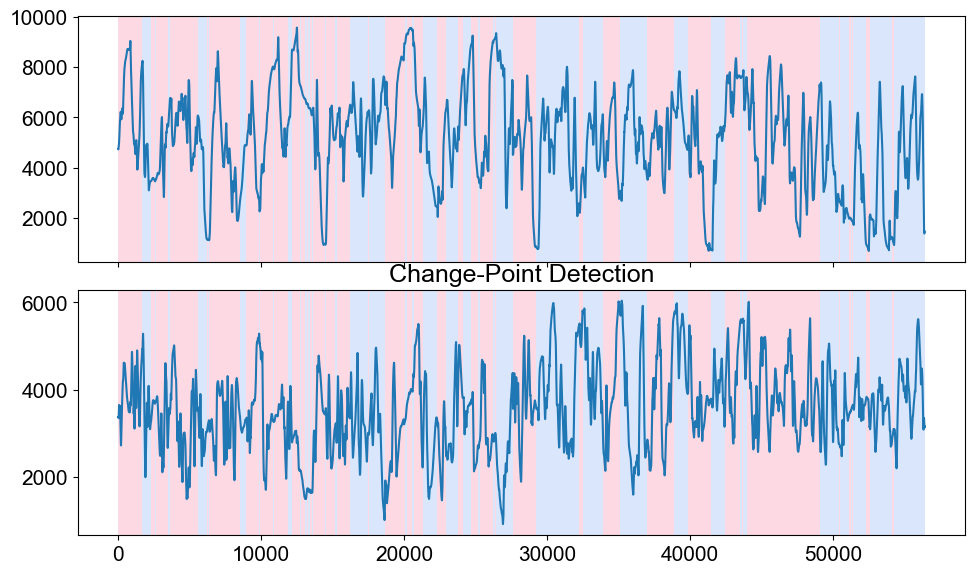

In [16]:

# Define the cost function and algorithm
model = "l2"  # Cost function
algorithm = rpt.Pelt(model=model)
penalty = 100  # Penalty value (tune based on your data)
change_points = algorithm.fit(t_series).predict(pen=penalty)

# Output detected change-points
print("Detected change-points:", change_points)
rpt.display(t_series, change_points, figsize=(10, 6))
plt.title("Change-Point Detection")
plt.show()

#### SoccerCPD:

In [17]:
# Install and import the R package 'gSeg' to be used in SoccerCPD
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
if not rpackages.isinstalled('gSeg'):
    utils.install_packages('gSeg')
rpackages.importr('gSeg')
if os.path.exists('data\\gseg_avg\\fgp\\17985.csv'):
    os.remove('data\\gseg_avg\\fgp\\17985.csv')
# Apply SoccerCPD on the preprocessed match data
cpd = SoccerCPD(match, formcpd_type='gseg_avg')
cpd.run()
cpd.visualize()
cpd.save_stats()


--------------------------------- Session 1 ----------------------------------
                 type session gametime            start_dt              end_dt
player_period                                                                 
1              START1       1    00~46 2020-01-01 19:00:00 2020-01-01 19:46:00

* Step 1: Frame-by-frame role assignment using RoleRep


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_fgp = self.ugp.groupby(LABEL_PLAYER_PERIOD).apply(RoleRep.generate_fgp, freq=freq)
C:\Users\Dell\

- Cost after iteration 1: 15.533


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.355


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.344


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.340
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying g-segmentation to the sequence between 19:00:01 and 19:46:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 1040 
  Test statistic: 1940.918 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 987 
  Test statistic: 9364.465 
  Approximated p-value: 0 
A significant fine-tuned change-point at 19:18:13.

Applying g-segmentation to the sequence between 19:00:01 and 19:18:13...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 936 
  Test statistic: 533.8787 
  Approximated p-value: 6.091984e-114 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 921 
  Test statistic: 655.7226 
  Approximated p-value: 2.317362e-140 
Change-point insignificant: One of the periods has not enough duration.

Applying g-segmentat

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppDat

- Cost after iteration 1: 15.561


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.436


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.422


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.414


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 5: 15.410
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying g-segmentation to the sequence between 20:01:01 and 20:49:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 842 
  Test statistic: 2089.862 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 839 
  Test statistic: 11290.47 
  Approximated p-value: 0 
A significant fine-tuned change-point at 20:14:00.

Applying g-segmentation to the sequence between 20:01:01 and 20:14:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 238 
  Test statistic: 589.857 
  Approximated p-value: 3.709284e-126 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 298 
  Test statistic: 1451.715 
  Approximated p-value: 3.300491e-313 
Change-point insignificant: One of the periods has not enough duration.

Applying g-segmentatio

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:481: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.fgp = self.fgp.groupby(LABEL_DATETIME, group_keys=False).apply(SoccerCPD.recompute_switch_rate)



------------------------------------------------------------------------------
Formation Periods:
   form_period  session            start_dt              end_dt  duration
0            1        1 2020-01-01 19:00:00 2020-01-01 19:18:10    1090.0
1            2        1 2020-01-01 19:18:10 2020-01-01 19:46:00    1670.0
2            3        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
3            4        2 2020-01-01 20:14:00 2020-01-01 20:49:00    2100.0

Role Periods:
   form_period  role_period  session            start_dt              end_dt  duration
0            1            1        1 2020-01-01 19:00:00 2020-01-01 19:18:10    1090.0
1            2            2        1 2020-01-01 19:18:10 2020-01-01 19:46:00    1670.0
2            3            3        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
3            4            4        2 2020-01-01 20:14:00 2020-01-01 20:41:00    1620.0
4            4            5        2 2020-01-01 20:41:00 2020-01-01 20:49:00     

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", 

'./data/gseg_avg/report/17985.png' saving done.
'./data/gseg_avg/fgp/17985.csv' saving done.
'./data/gseg_avg/form/17985.pkl' saving done.
'./data/gseg_avg/role/17985.csv' saving done.


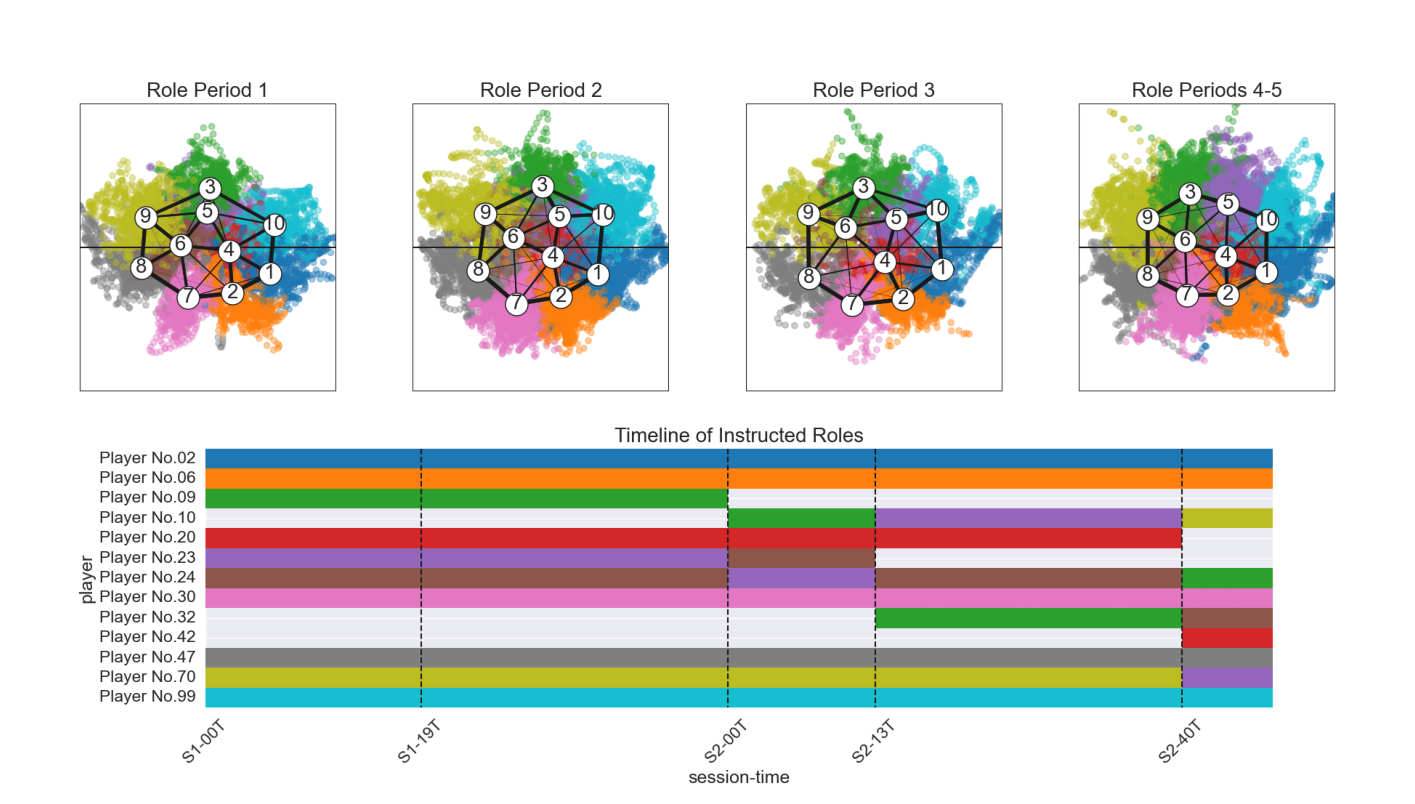

In [18]:
report_path = f'{DIR_DATA}/{cpd.formcpd_type}/report/{activity_id}.png'
img = mpimg.imread(report_path)
plt.figure(figsize=(18, 12))
plt.axis('off')
plt.imshow(img)
plt.show()

#### Experiment : Apply smoothing for each player using a moving average

In [19]:
# Apply smoothing for each player using a moving average
ugp[["x", "y"]] = (
    ugp.groupby("player_id")[["x", "y"]]
    .transform(lambda col: col.rolling(window=3, min_periods=1).mean())
)
ugp

player_id  session  gametime      unixtime  player_period  duration            x            y     speed
2020-01-01 18:26:49.100     1365.0      NaN       NaN  1.577903e+09            NaN       0.1  3362.000000  8191.000000  0.233274
2020-01-01 18:26:49.200     1365.0      NaN       NaN  1.577903e+09            NaN       0.1  3364.000000  8188.000000  0.318801
2020-01-01 18:26:49.300     1365.0      NaN       NaN  1.577903e+09            NaN       0.1  3364.666667  8185.666667  0.369413
2020-01-01 18:26:49.400     1365.0      NaN       NaN  1.577903e+09            NaN       0.1  3365.333333  8181.333333  0.391145
2020-01-01 18:26:49.500     1365.0      NaN       NaN  1.577903e+09            NaN       0.1  3363.333333  8178.666667  0.390031
...                            ...      ...       ...           ...            ...       ...          ...          ...       ...
2020-01-01 20:58:59.600     5608.0      NaN       NaN  1.577912e+09            NaN       0.1  4393.000000  4769.666667  5.710166
2020-01-01 20:58:59.700     5608.0      NaN       NaN  1.577912e+09            NaN       0.1  4381.333333  4760.000000  5.709115
2020-01-01 20:58:59.800     5608.0      NaN       NaN  1.577912e+09            NaN       0.1  4369.666667  4750.000000  5.708764
2020-01-01 20:58:59.900     5608.0      NaN       NaN  1.577912e+09            NaN       0.1  4358.333333  4739.333333  5.709465
2020-01-01 20:59:00.000     5608.0      NaN       NaN  1.577912e+09            NaN       0.1  4347.000000  4728.000000  5.711568

[635855 rows x 9 columns]

#### Experiment: Detect and Remove Outliers

In [20]:
from scipy.stats import zscore
# Combine x and y columns into a 2D array for joint z-score calculation
coords = ugp[['x', 'y']]

# Calculate z-scores for the 2D coordinates
z_scores = np.abs(zscore(coords, axis=0))  # Compute z-scores column-wise (for each coordinate separately)

# Set a threshold for outlier detection (typically 3)
threshold = 3

# Identify outliers where either x or y exceeds the threshold
outliers = (z_scores > threshold).any(axis=1)

# Filter the DataFrame to exclude outliers
ugp_cleaned = ugp[~outliers]

d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


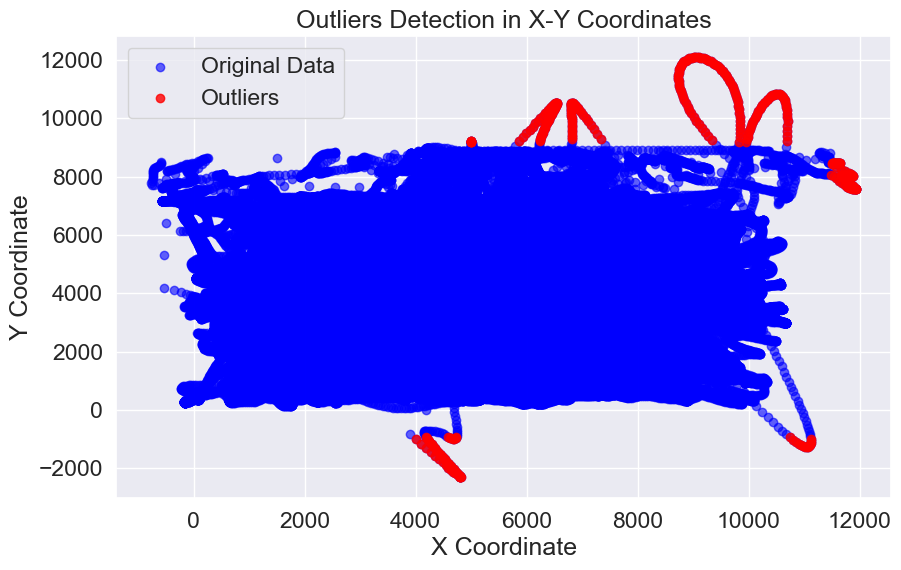

In [21]:
# Plot original data with outliers
plt.figure(figsize=(10, 6))
plt.scatter(ugp['x'], ugp['y'], label='Original Data', color='blue', alpha=0.6)

# Highlight the outliers in red
plt.scatter(ugp[outliers]['x'], ugp[outliers]['y'], label='Outliers', color='red', alpha=0.8)

plt.title('Outliers Detection in X-Y Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()

In [22]:
# Print statistics before removing outliers
print("Before removing outliers:")
print(ugp[['x', 'y']].describe())

# Print statistics after removing outliers
print("After removing outliers:")
print(ugp_cleaned[['x', 'y']].describe())

Before removing outliers:
                   x              y
count  635855.000000  635855.000000
mean     4996.691863    4139.072132
std      2162.369656    1684.139518
min      -763.000000   -2311.666667
25%      3507.500000    3052.666667
50%      5136.000000    4016.666667
75%      6563.000000    5242.000000
max     11930.000000   12092.666667
After removing outliers:
                   x              y
count  635483.000000  635483.000000
mean     4994.579978    4137.009933
std      2160.346005    1678.859006
min      -763.000000    -910.333333
25%      3506.333333    3052.333333
50%      5135.000000    4016.000000
75%      6561.000000    5239.666667
max     11480.666667    9189.666667


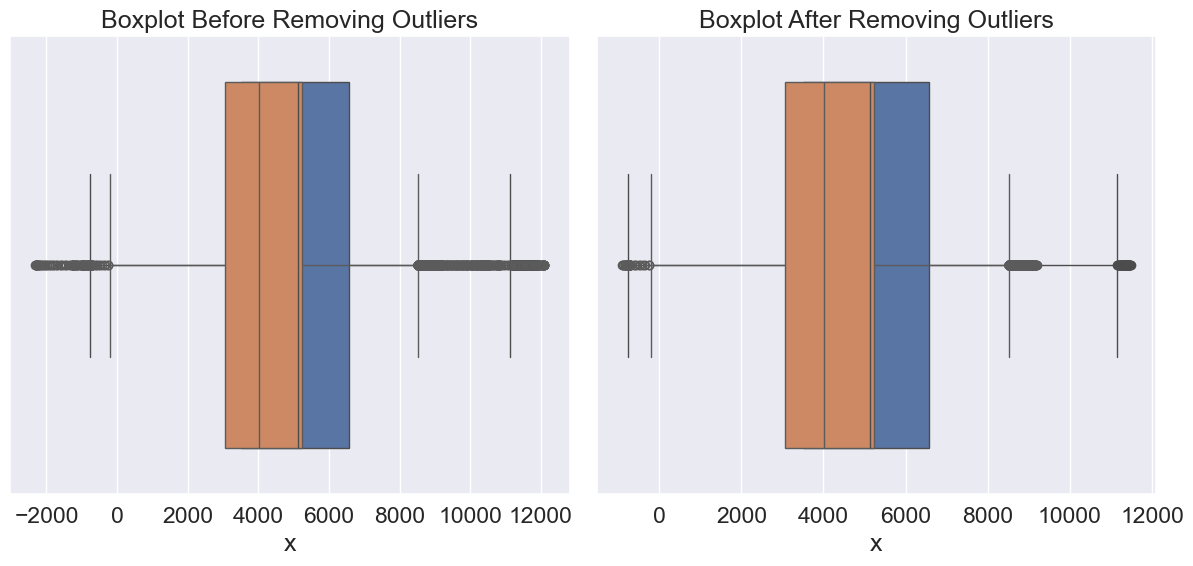

In [23]:
import seaborn as sns

# Boxplots before and after removing outliers for both x and y
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=ugp['x'])
sns.boxplot(x=ugp['y'])
plt.title('Boxplot Before Removing Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(x=ugp_cleaned['x'])
sns.boxplot(x=ugp_cleaned['y'])
plt.title('Boxplot After Removing Outliers')

plt.tight_layout()
plt.show()

In [24]:
# Further processing of UGP data using the official match log
match = Match(activity_record, player_periods, roster, ugp)

# (1) Filter in-play data from the measured data using the start, end, and substitution records
match.construct_inplay_ugp()

# (2) Rotate the pitch for one of the sessions so that the team always attacks from left to right
match.rotate_pitch()

match.ugp

player_id  session gametime      unixtime  player_period  duration            x            y     speed
2020-01-01 19:00:00.100       4181        1  00:00.1  1.577905e+09              1       0.1  4623.333333   583.666667  4.615196
2020-01-01 19:00:00.200       4181        1  00:00.2  1.577905e+09              1       0.1  4632.666667   573.000000  4.655973
2020-01-01 19:00:00.300       4181        1  00:00.3  1.577905e+09              1       0.1  4642.000000   561.000000  4.714858
2020-01-01 19:00:00.400       4181        1  00:00.4  1.577905e+09              1       0.1  4650.666667   547.666667  4.781228
2020-01-01 19:00:00.500       4181        1  00:00.5  1.577905e+09              1       0.1  4659.000000   533.666667  4.844462
...                            ...      ...      ...           ...            ...       ...          ...          ...       ...
2020-01-01 20:48:59.600       5527        2  47:59.6  1.577912e+09              4       0.1  1116.000000  2815.333333  1.856839
2020-01-01 20:48:59.700       5527        2  47:59.7  1.577912e+09              4       0.1  1121.666667  2817.333333  2.125829
2020-01-01 20:48:59.800       5527        2  47:59.8  1.577912e+09              4       0.1  1128.000000  2820.333333  2.457998
2020-01-01 20:48:59.900       5527        2  47:59.9  1.577912e+09              4       0.1  1135.000000  2824.000000  2.809422
2020-01-01 20:49:00.000       5527        2  48:00.0  1.577912e+09              4       0.1  1142.333333  2828.000000  3.136177

[733200 rows x 9 columns]

In [25]:
# Install and import the R package 'gSeg' to be used in SoccerCPD
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
if not rpackages.isinstalled('gSeg'):
    utils.install_packages('gSeg')
rpackages.importr('gSeg')

if os.path.exists('data\\gseg_avg\\fgp\\17985.csv'):
    os.remove('data\\gseg_avg\\fgp\\17985.csv')
# Apply SoccerCPD on the preprocessed match data
cpd = SoccerCPD(match, formcpd_type='gseg_avg')
cpd.run()
cpd.visualize()
cpd.save_stats()




--------------------------------- Session 1 ----------------------------------
                 type session gametime            start_dt              end_dt
player_period                                                                 
1              START1       1    00~46 2020-01-01 19:00:00 2020-01-01 19:46:00

* Step 1: Frame-by-frame role assignment using RoleRep


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_fgp = self.ugp.groupby(LABEL_PLAYER_PERIOD).apply(RoleRep.generate_fgp, freq=freq)
C:\Users\Dell\

- Cost after iteration 1: 15.533


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.355


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.343


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.339
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying g-segmentation to the sequence between 19:00:01 and 19:46:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 1047 
  Test statistic: 1896.128 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 989 
  Test statistic: 8525.435 
  Approximated p-value: 0 
A significant fine-tuned change-point at 19:18:41.

Applying g-segmentation to the sequence between 19:00:01 and 19:18:41...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 108 
  Test statistic: 577.101 
  Approximated p-value: 2.610708e-123 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 923 
  Test statistic: 588.7984 
  Approximated p-value: 7.594127e-126 
Change-point insignificant: One of the periods has not enough duration.

Applying g-segmentati

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppDat

- Cost after iteration 1: 15.561


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.436


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.421


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.414


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 5: 15.411
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying g-segmentation to the sequence between 20:01:01 and 20:49:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 840 
  Test statistic: 2214.567 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 840 
  Test statistic: 9019.252 
  Approximated p-value: 0 
A significant fine-tuned change-point at 20:14:00.

Applying g-segmentation to the sequence between 20:01:01 and 20:14:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 236 
  Test statistic: 546.2876 
  Approximated p-value: 1.03974e-116 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 296 
  Test statistic: 1384.156 
  Approximated p-value: 1.529104e-298 
Change-point insignificant: One of the periods has not enough duration.

Applying g-segmentatio

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:481: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.fgp = self.fgp.groupby(LABEL_DATETIME, group_keys=False).apply(SoccerCPD.recompute_switch_rate)



------------------------------------------------------------------------------
Formation Periods:
   form_period  session            start_dt              end_dt  duration
0            1        1 2020-01-01 19:00:00 2020-01-01 19:18:40    1120.0
1            2        1 2020-01-01 19:18:40 2020-01-01 19:46:00    1640.0
2            3        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
3            4        2 2020-01-01 20:14:00 2020-01-01 20:49:00    2100.0

Role Periods:
   form_period  role_period  session            start_dt              end_dt  duration
0            1            1        1 2020-01-01 19:00:00 2020-01-01 19:18:40    1120.0
1            2            2        1 2020-01-01 19:18:40 2020-01-01 19:46:00    1640.0
2            3            3        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
3            4            4        2 2020-01-01 20:14:00 2020-01-01 20:41:00    1620.0
4            4            5        2 2020-01-01 20:41:00 2020-01-01 20:49:00     

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", 

'./data/gseg_avg/report/17985.png' saving done.
'./data/gseg_avg/fgp/17985.csv' saving done.
'./data/gseg_avg/form/17985.pkl' saving done.
'./data/gseg_avg/role/17985.csv' saving done.


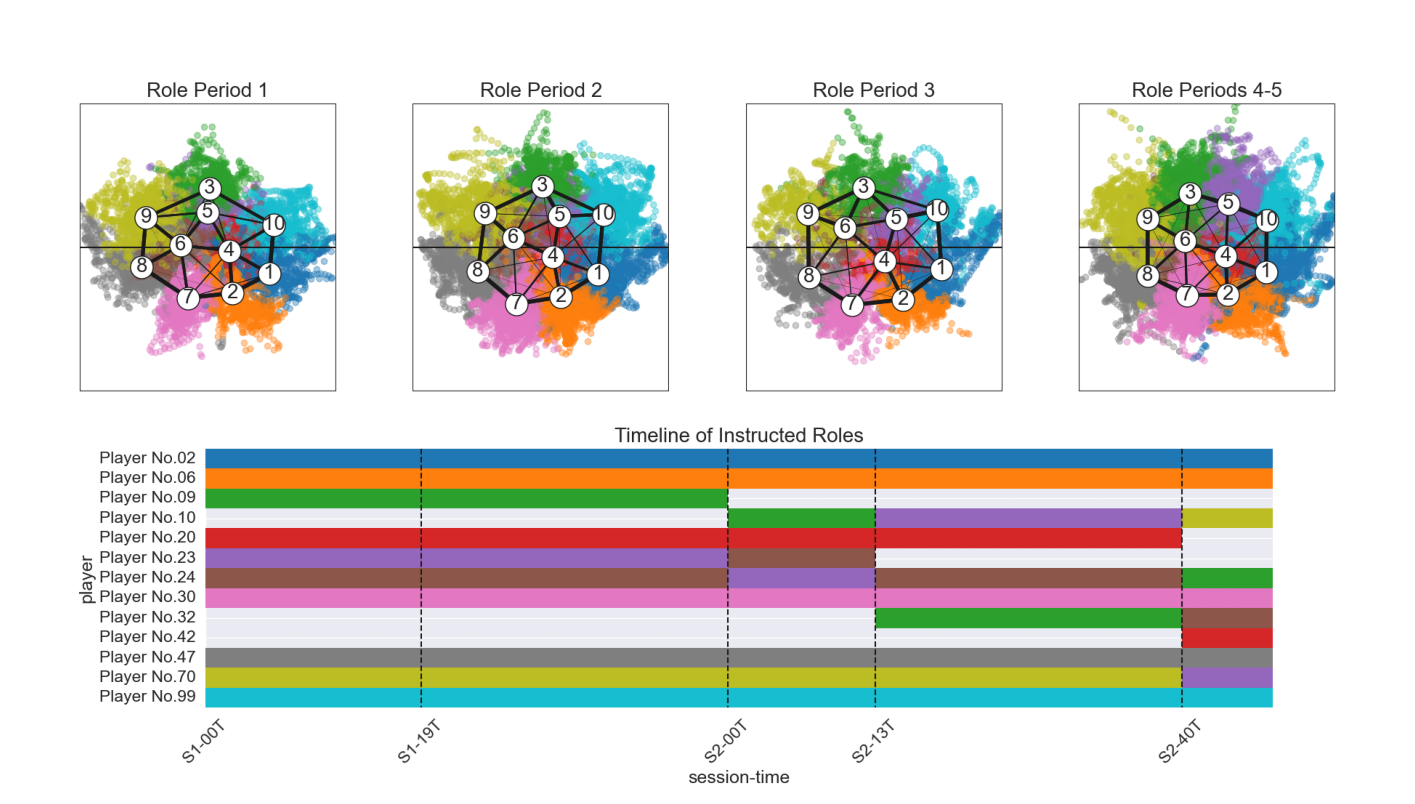

In [26]:
report_path = f'{DIR_DATA}/{cpd.formcpd_type}/report/{activity_id}.png'
img = mpimg.imread(report_path)
plt.figure(figsize=(18, 12))
plt.axis('off')
plt.imshow(img)
plt.show()

#### Experiment 2 : comparing with ground truth

In [27]:
#Ground-Truth role period
df=pd.read_csv('./data/role_tags_true.csv')
filtered_df = df[df['activity_id'] == 17985]
unique_filtered_df = filtered_df.drop_duplicates(subset=['start_time', 'end_time']).reset_index(drop=True)
selected_columns=['activity_id','role_period','session','start_time','end_time']
print(unique_filtered_df[selected_columns])

   activity_id  role_period  session  start_time  end_time
0        17985            1        1           0        19
1        17985            2        1          19        46
2        17985            3        2           0        13
3        17985            4        2          13        40
4        17985            5        2          40        48


In [28]:
def plot_gantt_chart(data):
    """Plots a Gantt chart with time intervals (in minutes)."""
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (role, (start, end)) in enumerate(data.items()):
        width = end - start
        ax.barh(role, width, left=start, height=0.5, color="skyblue", edgecolor="black")

        # Format time with seconds (if needed)
        start_h = int(start // 60) #cast to int
        start_m = int(start % 60) #cast to int
        start_s = int(round((start % 1) * 60)) if isinstance(start, float) else 0  # Round seconds
        end_h = int(end // 60) #cast to int
        end_m = int(end % 60) #cast to int
        end_s = int(round((end % 1) * 60)) if isinstance(end, float) else 0 # Round seconds

        time_text = f"{start_h:02d}:{start_m:02d}:{start_s:02d} - {end_h:02d}:{end_m:02d}:{end_s:02d}"
        ax.text(start + width / 2, role, time_text, ha="center", va="center", color="black")

    ax.set_xlabel("Time (minutes from start of the day)")
    ax.set_yticks(list(data.keys()))
    ax.set_yticklabels(list(data.keys()))
    min_time = min([start for _, (start,_) in data.items()])
    max_time = max([end for _, (_,end) in data.items()])
    ax.set_xlim(min_time - 5, max_time + 5)
    ax.invert_yaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_title("Role Periods and Time Intervals", fontsize=14)
    plt.tight_layout()
    plt.show()

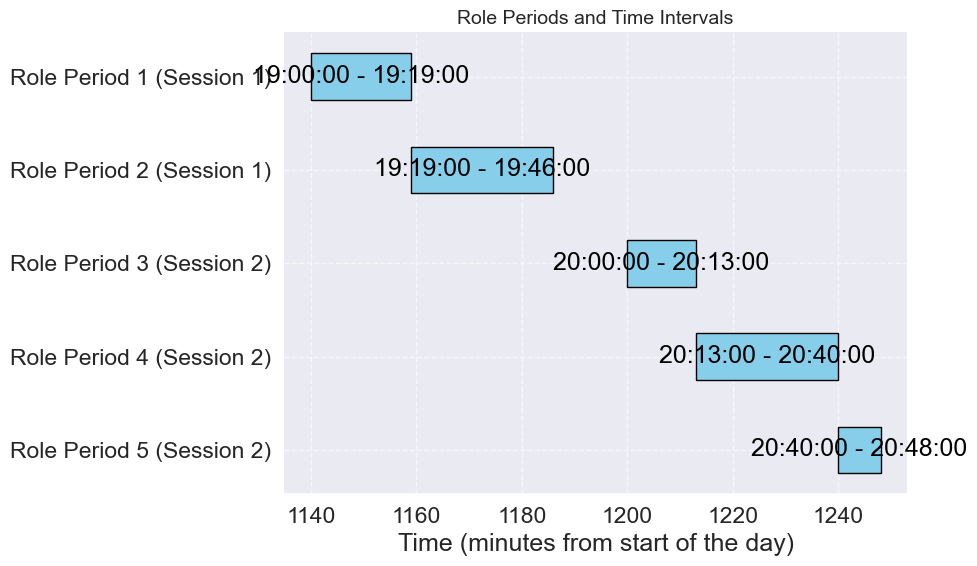

In [29]:
# Data for the role periods
truth_chg_pts = {
    "Role Period 1 (Session 1)": (1140.0, 1159.0),  # 19:00 - 19:19
    "Role Period 2 (Session 1)": (1159.0, 1186.0),  # 19:19 - 19:46
    "Role Period 3 (Session 2)": (1200.0, 1213.0),  # 20:00 - 20:13
    "Role Period 4 (Session 2)": (1213.0, 1240.0),  # 20:13 - 20:40
    "Role Period 5 (Session 2)": (1240.0, 1248.0),  # 20:40 - 20:48
}
plot_gantt_chart(truth_chg_pts)

#### Without our preprocessing :

Given that the match first session starts at 19h00: The first ground truth role period  is between **19h00--19h19**. The predicted role change point was at **19:18:10**.  

The second ground truth role period  is between **19h19--19h46**. The predicted role change point was at **19:46:00**.  

Given that the match second session starts at 20h00: The third ground truth role period  is between **20h00--20h13**.The predicted role change point was at **20:14:00**.  

The fourth ground truth role period  is between **20h13--20h40**. The predicted role change point was at **20:41:00**.  

The fifth  ground truth role period  is between **20h40--20h48**. The predicted role change point was at **20:49:00**.


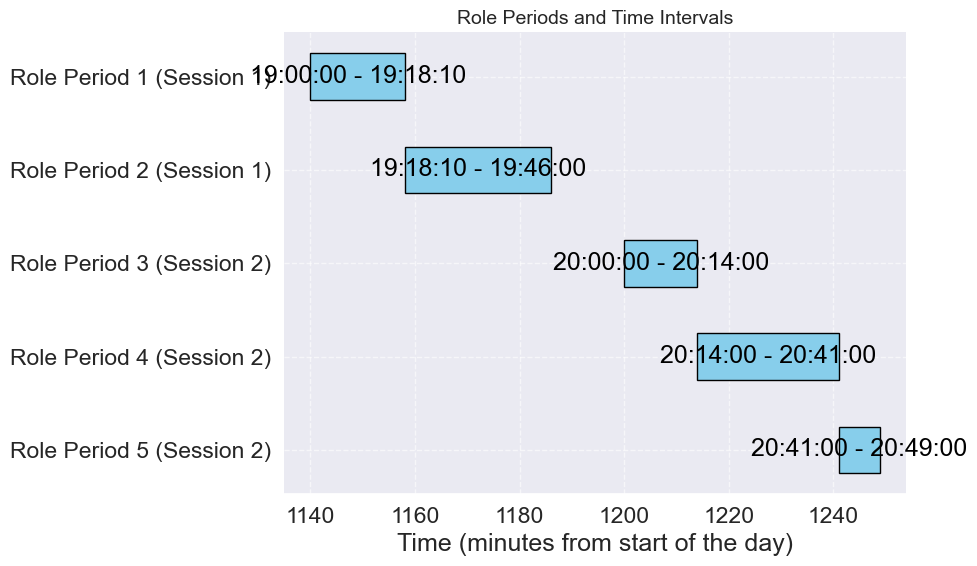

In [30]:
# Example usage (with floats for seconds)
pred_chg_pts_seconds = {
    "Role Period 1 (Session 1)": (1140.0, 1158.166),  # 19:00 - 19:18:10 (1/6 of a minute)
    "Role Period 2 (Session 1)": (1158.166, 1186.0),  # 19:18:10 - 19:46
    "Role Period 3 (Session 2)": (1200.0, 1214),  # 20:00 - 20:14
    "Role Period 4 (Session 2)": (1214, 1241),  # 20:14 - 20:41
    "Role Period 5 (Session 2)": (1241, 1249),  # 20:40:15 - 20:49
}

plot_gantt_chart(pred_chg_pts_seconds)

#### With our pre-processing :

Given that the match first session starts at 19h00: The first ground truth role period  is between **19h00--19h19**. The predicted role change point was at **19:18:40**.  

The second ground truth role period  is between **19h19--19h46**. The predicted role change point was at **19:46:00**.  

Given that the match second session starts at 20h00: The third ground truth role period  is between **20h00--20h13**.The predicted role change point was at **20:14:00**.  

The fourth ground truth role period  is between **20h13--20h40**. The predicted role change point was at **20:41:00**.  

The fifth  ground truth role period  is between **20h40--20h48**. The predicted role change point was at **20:49:00**.


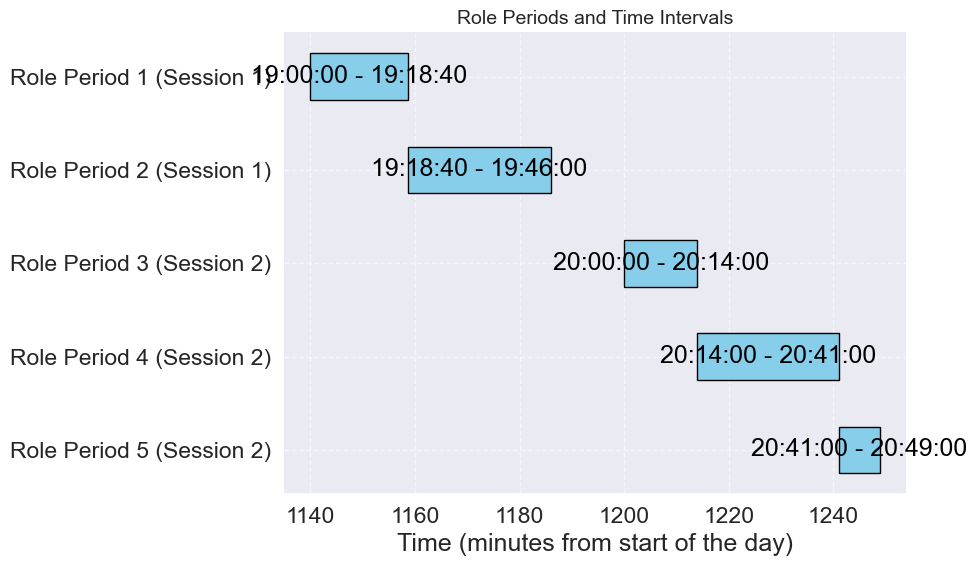

In [31]:

# Example usage (with floats for seconds)
pred_chg_pts_seconds = {
    "Role Period 1 (Session 1)": (1140.0, 1158.666),  # 19:00 - 19:18:40 (2/3 of a minute)
    "Role Period 2 (Session 1)": (1158.666, 1186.0),  # 19:18:40 - 19:46
    "Role Period 3 (Session 2)": (1200.0, 1214),  # 20:00 - 20:14
    "Role Period 4 (Session 2)": (1214, 1241),  # 20:14 - 20:41
    "Role Period 5 (Session 2)": (1241, 1249),  # 20:41 - 20:49
}

plot_gantt_chart(pred_chg_pts_seconds)

##### Experiment : Trying other types of FormCPD ( 'gseg_union', 'kernel_linear', 'kernel_rbf', 'kernel_cosine', 'rank')

#### gSeg union

In [32]:
# Apply SoccerCPD on the preprocessed match data

cpd = SoccerCPD(match, formcpd_type='gseg_union')
cpd.run()
cpd.visualize()
cpd.save_stats()


--------------------------------- Session 1 ----------------------------------
                 type session gametime            start_dt              end_dt
player_period                                                                 
1              START1       1    00~46 2020-01-01 19:00:00 2020-01-01 19:46:00

* Step 1: Frame-by-frame role assignment using RoleRep


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_fgp = self.ugp.groupby(LABEL_PLAYER_PERIOD).apply(RoleRep.generate_fgp, freq=freq)
C:\Users\Dell\

- Cost after iteration 1: 15.533


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.355


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.343


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.339
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying g-segmentation to the sequence between 19:00:01 and 19:46:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 1047 
  Test statistic: 1896.128 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 989 
  Test statistic: 8525.435 
  Approximated p-value: 0 
A significant fine-tuned change-point at 19:17:11.

Applying g-segmentation to the sequence between 19:00:01 and 19:17:11...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 99 
  Test statistic: 657.6999 
  Approximated p-value: 8.399899e-141 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 884 
  Test statistic: 813.8927 
  Approximated p-value: 1.100353e-174 
Change-point insignificant: One of the periods has not enough duration.

Applying g-segmentati

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppDat

- Cost after iteration 1: 15.561


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.436


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.421


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.414


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 5: 15.411
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying g-segmentation to the sequence between 20:01:01 and 20:49:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 840 
  Test statistic: 2214.567 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 840 
  Test statistic: 9019.252 
  Approximated p-value: 0 
A significant fine-tuned change-point at 20:14:00.

Applying g-segmentation to the sequence between 20:01:01 and 20:14:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 236 
  Test statistic: 546.2876 
  Approximated p-value: 1.03974e-116 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 296 
  Test statistic: 1384.156 
  Approximated p-value: 1.529104e-298 
Change-point insignificant: One of the periods has not enough duration.

Applying g-segmentatio

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:481: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.fgp = self.fgp.groupby(LABEL_DATETIME, group_keys=False).apply(SoccerCPD.recompute_switch_rate)



------------------------------------------------------------------------------
Formation Periods:
   form_period  session            start_dt              end_dt  duration
0            1        1 2020-01-01 19:00:00 2020-01-01 19:17:10    1030.0
1            2        1 2020-01-01 19:17:10 2020-01-01 19:46:00    1730.0
2            3        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
3            4        2 2020-01-01 20:14:00 2020-01-01 20:49:00    2100.0

Role Periods:
   form_period  role_period  session            start_dt              end_dt  duration
0            1            1        1 2020-01-01 19:00:00 2020-01-01 19:17:10    1030.0
1            2            2        1 2020-01-01 19:17:10 2020-01-01 19:46:00    1730.0
2            3            3        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
3            4            4        2 2020-01-01 20:14:00 2020-01-01 20:41:00    1620.0
4            4            5        2 2020-01-01 20:41:00 2020-01-01 20:49:00     

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", 

'./data/gseg_union/report/17985.png' saving done.
'./data/gseg_union/fgp/17985.csv' saving done.
'./data/gseg_union/form/17985.pkl' saving done.
'./data/gseg_union/role/17985.csv' saving done.


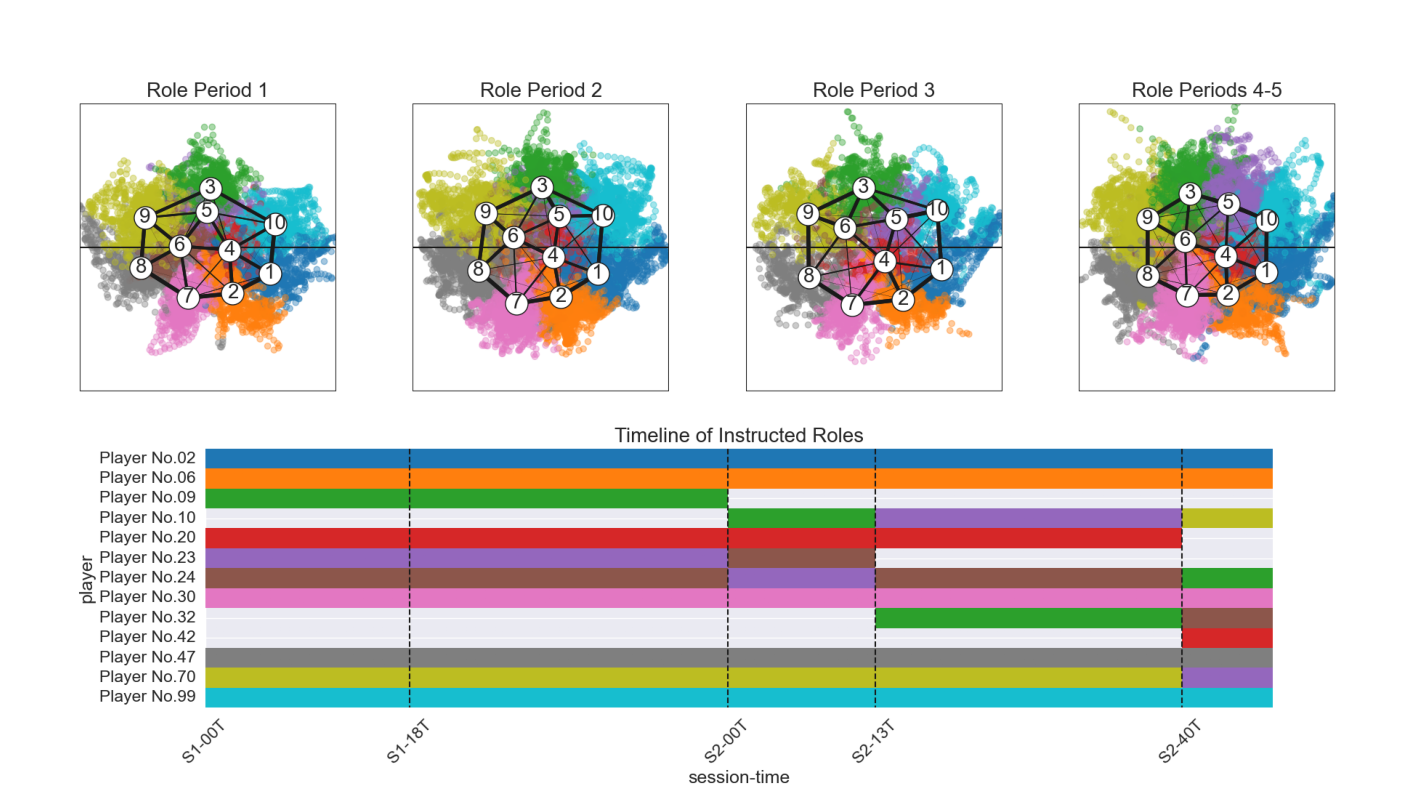

In [33]:
report_path = f'{DIR_DATA}/{cpd.formcpd_type}/report/{activity_id}.png'
img = mpimg.imread(report_path)
plt.figure(figsize=(18, 12))
plt.axis('off')
plt.imshow(img)
plt.show()

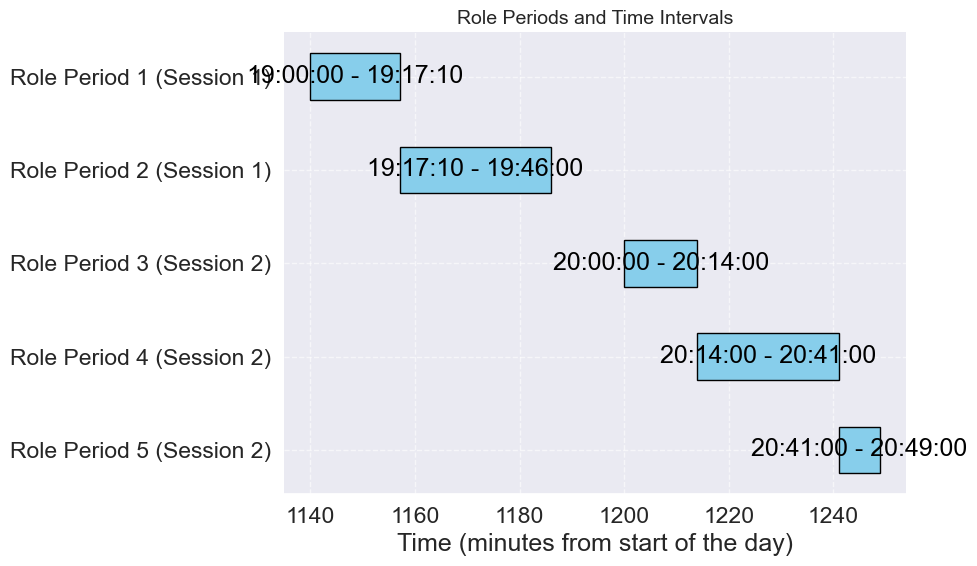

In [34]:

# Example usage (with floats for seconds)
pred_chg_pts_seconds = {
    "Role Period 1 (Session 1)": (1140.0, 1157.166),  # 19:00 - 19:17:10 (1/6 of a minute)
    "Role Period 2 (Session 1)": (1157.166, 1186.0),  # 19:17:10 - 19:46
    "Role Period 3 (Session 2)": (1200.0, 1214),  # 20:00 - 20:14
    "Role Period 4 (Session 2)": (1214, 1241),  # 20:14 - 20:41
    "Role Period 5 (Session 2)": (1241, 1249),  # 20:41 - 20:49
}

plot_gantt_chart(pred_chg_pts_seconds)

In [35]:
# Apply SoccerCPD on the preprocessed match data
cpd = SoccerCPD(match, formcpd_type='kernel_linear')
cpd.run()
cpd.visualize()
cpd.save_stats()


--------------------------------- Session 1 ----------------------------------
                 type session gametime            start_dt              end_dt
player_period                                                                 
1              START1       1    00~46 2020-01-01 19:00:00 2020-01-01 19:46:00

* Step 1: Frame-by-frame role assignment using RoleRep


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_fgp = self.ugp.groupby(LABEL_PLAYER_PERIOD).apply(RoleRep.generate_fgp, freq=freq)
C:\Users\Dell\

- Cost after iteration 1: 15.533


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.355


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.343


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.339
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying kernel-based CPD to the sequence between 19:00:01 and 19:46:00...
Change-point insignificant: One of the periods has not enough duration.

Detected formation change-points (rounded off to the nearest 10 second mark):
[]

* Step 3: RoleCPD per formation period based on role permutations

RoleCPD for the formation period 1:
Applying g-segmentation to the sequence between 19:00:01 and 19:46:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 2156 
  Test statistic: 4535.924 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 443 
  Test statistic: 4389.75 
  Approximated p-value: 0 
Change-point insignificant: One of the periods has not enough duration.

Detected role change-points (rounded off to the nearset 10 second mark):
[]

------------------------------

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppDat

- Cost after iteration 1: 15.561


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.436


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.421


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.414


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 5: 15.411
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying kernel-based CPD to the sequence between 20:01:01 and 20:49:00...
Change-point insignificant: One of the periods has not enough duration.

Detected formation change-points (rounded off to the nearest 10 second mark):
[]

* Step 3: RoleCPD per formation period based on role permutations

RoleCPD for the formation period 2:
Applying g-segmentation to the sequence between 20:01:01 and 20:49:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 2328 
  Test statistic: 17913.45 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 2268 
  Test statistic: 143327.8 
  Approximated p-value: 0 
A significant fine-tuned change-point at 20:41:00.
- Frequent permutations before 20:41:00:
[('[ 1  2  3  4  5  6  7  8  9 10]', 868),
 ('[ 1  2  3  4 10  6  7  8  9  5]', 168),


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:481: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.fgp = self.fgp.groupby(LABEL_DATETIME, group_keys=False).apply(SoccerCPD.recompute_switch_rate)



------------------------------------------------------------------------------
Formation Periods:
   form_period  session            start_dt              end_dt  duration
0            1        1 2020-01-01 19:00:00 2020-01-01 19:46:00    2760.0
1            2        2 2020-01-01 20:01:00 2020-01-01 20:49:00    2880.0

Role Periods:
   form_period  role_period  session            start_dt              end_dt  duration
0            1            1        1 2020-01-01 19:00:00 2020-01-01 19:46:00    2760.0
1            2            2        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
2            2            3        2 2020-01-01 20:14:00 2020-01-01 20:41:00    1620.0
3            2            4        2 2020-01-01 20:41:00 2020-01-01 20:49:00     480.0



C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", 

'./data/kernel_linear/report/17985.png' saving done.
'./data/kernel_linear/fgp/17985.csv' saving done.
'./data/kernel_linear/form/17985.pkl' saving done.
'./data/kernel_linear/role/17985.csv' saving done.


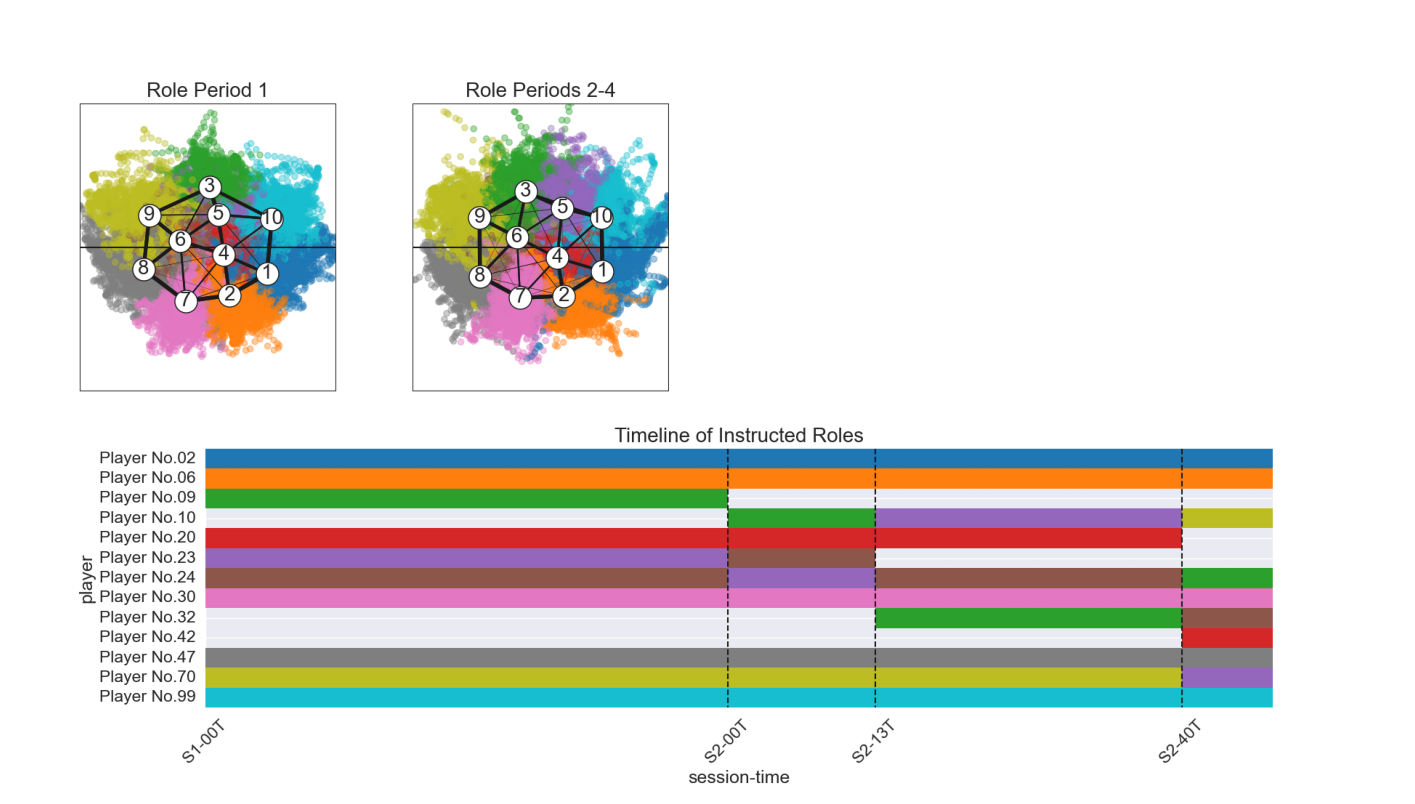

In [36]:
report_path = f'{DIR_DATA}/{cpd.formcpd_type}/report/{activity_id}.png'
img = mpimg.imread(report_path)
plt.figure(figsize=(18, 12))
plt.axis('off')
plt.imshow(img)
plt.show()

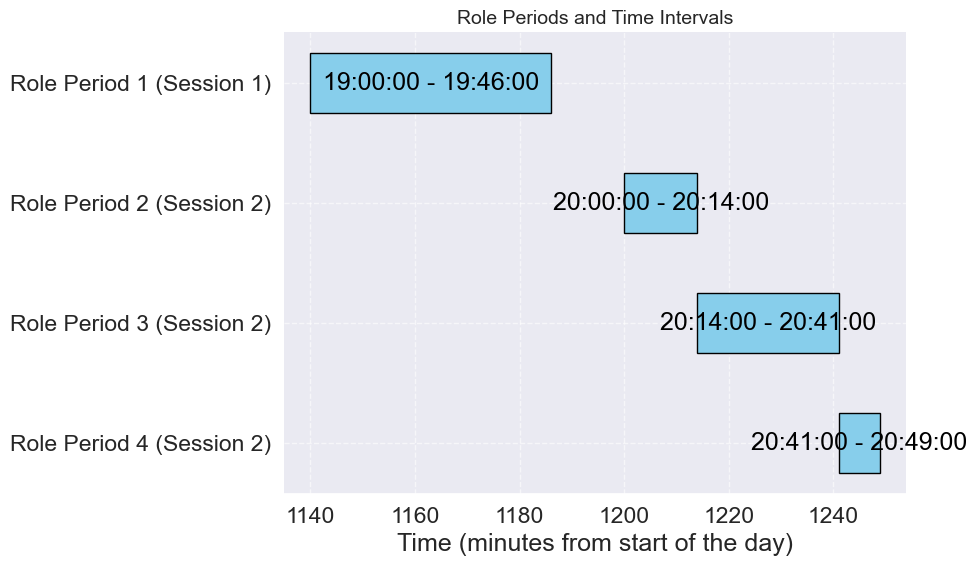

In [37]:
# Example usage (with floats for seconds)
pred_chg_pts_seconds = {
    "Role Period 1 (Session 1)": (1140.0, 1186),  # 19:00 - 19:46
    
    "Role Period 2 (Session 2)": (1200.0, 1214),  # 20:00 - 20:14
    "Role Period 3 (Session 2)": (1214, 1241),  # 20:14 - 20:41
    "Role Period 4 (Session 2)": (1241, 1249),  # 20:41 - 20:49
}

plot_gantt_chart(pred_chg_pts_seconds)

In [38]:
# Apply SoccerCPD on the preprocessed match data
cpd = SoccerCPD(match, formcpd_type='kernel_rbf')
cpd.run()
cpd.visualize()
cpd.save_stats()


--------------------------------- Session 1 ----------------------------------
                 type session gametime            start_dt              end_dt
player_period                                                                 
1              START1       1    00~46 2020-01-01 19:00:00 2020-01-01 19:46:00

* Step 1: Frame-by-frame role assignment using RoleRep


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_fgp = self.ugp.groupby(LABEL_PLAYER_PERIOD).apply(RoleRep.generate_fgp, freq=freq)
C:\Users\Dell\

- Cost after iteration 1: 15.533


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.355


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.343


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.339
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying kernel-based CPD to the sequence between 19:00:01 and 19:46:00...
A significant fine-tuned change-point at 19:17:12.

Applying kernel-based CPD to the sequence between 19:00:01 and 19:17:12...
Change-point insignificant: One of the periods has not enough duration.

Applying kernel-based CPD to the sequence between 19:17:12 and 19:46:00...
Change-point insignificant: The formation is not changed.

Detected formation change-points (rounded off to the nearest 10 second mark):
[Timestamp('2020-01-01 19:17:10')]

* Step 3: RoleCPD per formation period based on role permutations

RoleCPD for the formation period 1:
Applying g-segmentation to the sequence between 19:00:01 and 19:17:10...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 99 
  Test statistic: 1709.918 
  Approximated p-value: 0 
Generalized edge-count 

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppDat

- Cost after iteration 1: 15.561


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.436


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.421


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.414


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 5: 15.411
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying kernel-based CPD to the sequence between 20:01:01 and 20:49:00...
A significant fine-tuned change-point at 20:14:00.

Applying kernel-based CPD to the sequence between 20:01:01 and 20:14:00...
Change-point insignificant: One of the periods has not enough duration.

Applying kernel-based CPD to the sequence between 20:14:00 and 20:49:00...
Change-point insignificant: The formation is not changed.

Detected formation change-points (rounded off to the nearest 10 second mark):
[Timestamp('2020-01-01 20:14:00')]

* Step 3: RoleCPD per formation period based on role permutations

RoleCPD for the formation period 3:
Applying g-segmentation to the sequence between 20:01:01 and 20:14:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 221 
  Test statistic: 2394.104 
  Approximated p-value: 0 
Generalized edge-count

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:481: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.fgp = self.fgp.groupby(LABEL_DATETIME, group_keys=False).apply(SoccerCPD.recompute_switch_rate)



------------------------------------------------------------------------------
Formation Periods:
   form_period  session            start_dt              end_dt  duration
0            1        1 2020-01-01 19:00:00 2020-01-01 19:17:10    1030.0
1            2        1 2020-01-01 19:17:10 2020-01-01 19:46:00    1730.0
2            3        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
3            4        2 2020-01-01 20:14:00 2020-01-01 20:49:00    2100.0

Role Periods:
   form_period  role_period  session            start_dt              end_dt  duration
0            1            1        1 2020-01-01 19:00:00 2020-01-01 19:17:10    1030.0
1            2            2        1 2020-01-01 19:17:10 2020-01-01 19:46:00    1730.0
2            3            3        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
3            4            4        2 2020-01-01 20:14:00 2020-01-01 20:41:00    1620.0
4            4            5        2 2020-01-01 20:41:00 2020-01-01 20:49:00     

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", 

'./data/kernel_rbf/report/17985.png' saving done.
'./data/kernel_rbf/fgp/17985.csv' saving done.
'./data/kernel_rbf/form/17985.pkl' saving done.
'./data/kernel_rbf/role/17985.csv' saving done.


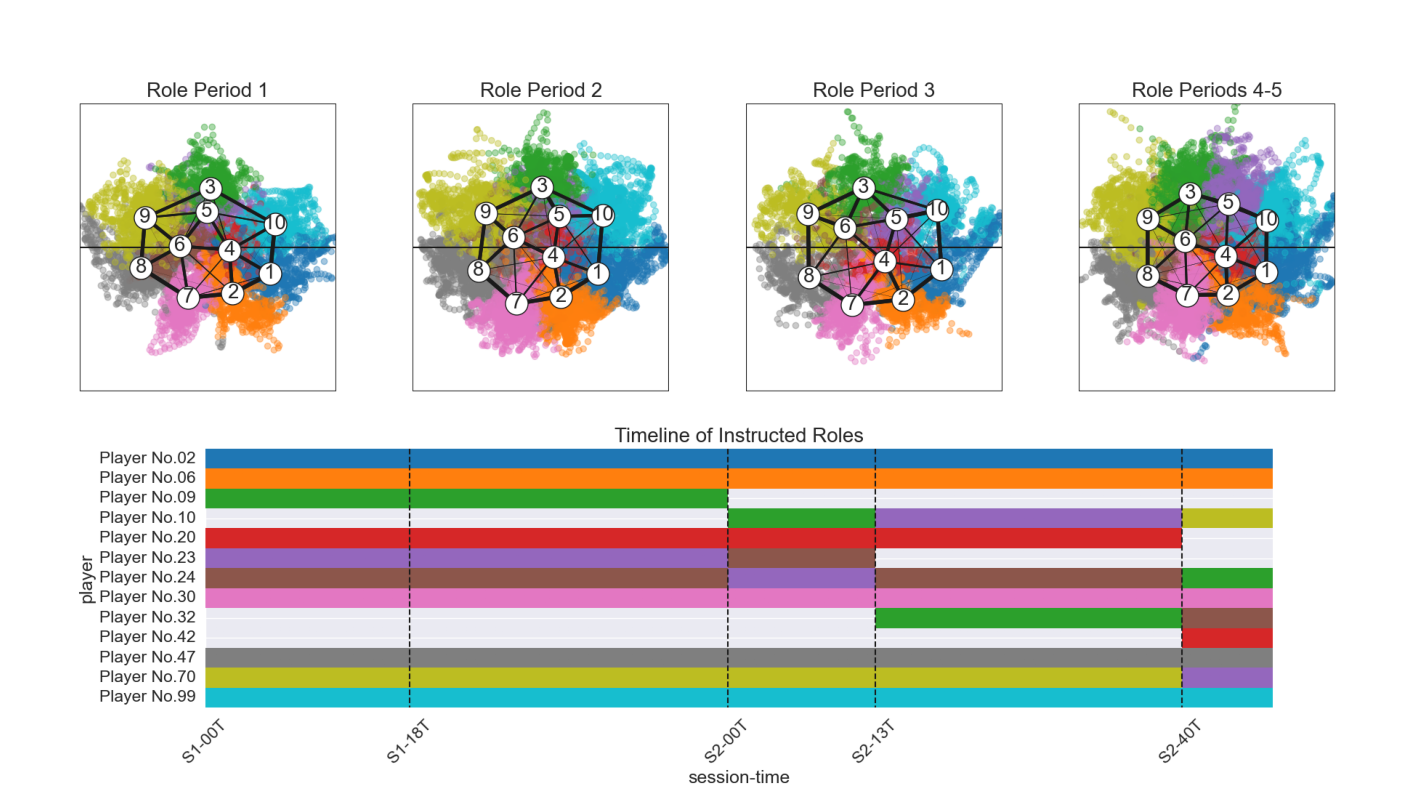

In [39]:
report_path = f'{DIR_DATA}/{cpd.formcpd_type}/report/{activity_id}.png'
img = mpimg.imread(report_path)
plt.figure(figsize=(18, 12))
plt.axis('off')
plt.imshow(img)
plt.show()

In [40]:
# Apply SoccerCPD on the preprocessed match data
cpd = SoccerCPD(match, formcpd_type='kernel_cosine')
cpd.run()
cpd.visualize()
cpd.save_stats()


--------------------------------- Session 1 ----------------------------------
                 type session gametime            start_dt              end_dt
player_period                                                                 
1              START1       1    00~46 2020-01-01 19:00:00 2020-01-01 19:46:00

* Step 1: Frame-by-frame role assignment using RoleRep


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_fgp = self.ugp.groupby(LABEL_PLAYER_PERIOD).apply(RoleRep.generate_fgp, freq=freq)
C:\Users\Dell\

- Cost after iteration 1: 15.533


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.355


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.343


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.339
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying kernel-based CPD to the sequence between 19:00:01 and 19:46:00...
A significant fine-tuned change-point at 19:17:12.

Applying kernel-based CPD to the sequence between 19:00:01 and 19:17:12...
Change-point insignificant: The formation is not changed.

Applying kernel-based CPD to the sequence between 19:17:12 and 19:46:00...
Change-point insignificant: The formation is not changed.

Detected formation change-points (rounded off to the nearest 10 second mark):
[Timestamp('2020-01-01 19:17:10')]

* Step 3: RoleCPD per formation period based on role permutations

RoleCPD for the formation period 1:
Applying g-segmentation to the sequence between 19:00:01 and 19:17:10...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 99 
  Test statistic: 1709.918 
  Approximated p-value: 0 
Generalized edge-count statistic (u) 

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppDat

- Cost after iteration 1: 15.561


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.436


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.421


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.414


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 5: 15.411
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying kernel-based CPD to the sequence between 20:01:01 and 20:49:00...
A significant fine-tuned change-point at 20:14:00.

Applying kernel-based CPD to the sequence between 20:01:01 and 20:14:00...
Change-point insignificant: One of the periods has not enough duration.

Applying kernel-based CPD to the sequence between 20:14:00 and 20:49:00...
Change-point insignificant: The formation is not changed.

Detected formation change-points (rounded off to the nearest 10 second mark):
[Timestamp('2020-01-01 20:14:00')]

* Step 3: RoleCPD per formation period based on role permutations

RoleCPD for the formation period 3:
Applying g-segmentation to the sequence between 20:01:01 and 20:14:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 221 
  Test statistic: 2394.104 
  Approximated p-value: 0 
Generalized edge-count

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:481: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.fgp = self.fgp.groupby(LABEL_DATETIME, group_keys=False).apply(SoccerCPD.recompute_switch_rate)



------------------------------------------------------------------------------
Formation Periods:
   form_period  session            start_dt              end_dt  duration
0            1        1 2020-01-01 19:00:00 2020-01-01 19:17:10    1030.0
1            2        1 2020-01-01 19:17:10 2020-01-01 19:46:00    1730.0
2            3        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
3            4        2 2020-01-01 20:14:00 2020-01-01 20:49:00    2100.0

Role Periods:
   form_period  role_period  session            start_dt              end_dt  duration
0            1            1        1 2020-01-01 19:00:00 2020-01-01 19:17:10    1030.0
1            2            2        1 2020-01-01 19:17:10 2020-01-01 19:46:00    1730.0
2            3            3        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
3            4            4        2 2020-01-01 20:14:00 2020-01-01 20:41:00    1620.0
4            4            5        2 2020-01-01 20:41:00 2020-01-01 20:49:00     

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", 

'./data/kernel_cosine/report/17985.png' saving done.
'./data/kernel_cosine/fgp/17985.csv' saving done.
'./data/kernel_cosine/form/17985.pkl' saving done.
'./data/kernel_cosine/role/17985.csv' saving done.


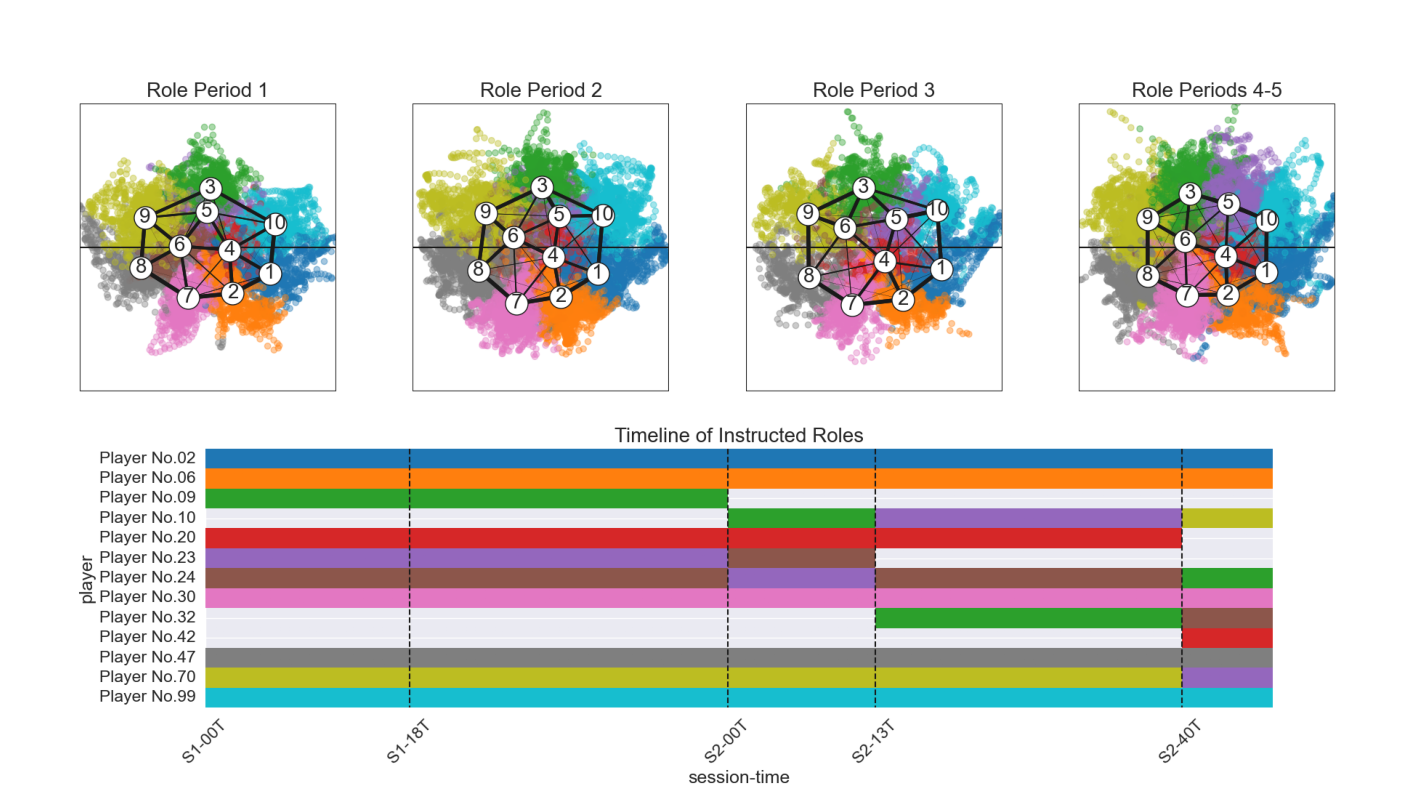

In [41]:
report_path = f'{DIR_DATA}/{cpd.formcpd_type}/report/{activity_id}.png'
img = mpimg.imread(report_path)
plt.figure(figsize=(18, 12))
plt.axis('off')
plt.imshow(img)
plt.show()

In [42]:
# Apply SoccerCPD on the preprocessed match data
cpd = SoccerCPD(match, formcpd_type='rank')
cpd.run()
cpd.visualize()
cpd.save_stats()


--------------------------------- Session 1 ----------------------------------
                 type session gametime            start_dt              end_dt
player_period                                                                 
1              START1       1    00~46 2020-01-01 19:00:00 2020-01-01 19:46:00

* Step 1: Frame-by-frame role assignment using RoleRep


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_fgp = self.ugp.groupby(LABEL_PLAYER_PERIOD).apply(RoleRep.generate_fgp, freq=freq)
C:\Users\Dell\

- Cost after iteration 1: 15.533


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.355


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.343


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.339
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying rank-based CPD to the sequence between 19:00:01 and 19:46:00...
A significant fine-tuned change-point at 19:18:16.

Applying rank-based CPD to the sequence between 19:00:01 and 19:18:16...
Change-point insignificant: One of the periods has not enough duration.

Applying rank-based CPD to the sequence between 19:18:16 and 19:46:00...
Change-point insignificant: One of the periods has not enough duration.

Detected formation change-points (rounded off to the nearest 10 second mark):
[Timestamp('2020-01-01 19:18:10')]

* Step 3: RoleCPD per formation period based on role permutations

RoleCPD for the formation period 1:
Applying g-segmentation to the sequence between 19:00:01 and 19:18:10...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 104 
  Test statistic: 1348.081 
  Approximated p-value: 1.326317e-290 
Ge

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppDat

- Cost after iteration 1: 15.561


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.436


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.421


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.414


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 5: 15.411
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying rank-based CPD to the sequence between 20:01:01 and 20:49:00...
A significant fine-tuned change-point at 20:14:00.

Applying rank-based CPD to the sequence between 20:01:01 and 20:14:00...
Change-point insignificant: One of the periods has not enough duration.

Applying rank-based CPD to the sequence between 20:14:00 and 20:49:00...
Change-point insignificant: The formation is not changed.

Detected formation change-points (rounded off to the nearest 10 second mark):
[Timestamp('2020-01-01 20:14:00')]

* Step 3: RoleCPD per formation period based on role permutations

RoleCPD for the formation period 3:
Applying g-segmentation to the sequence between 20:01:01 and 20:14:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 221 
  Test statistic: 2394.104 
  Approximated p-value: 0 
Generalized edge-count stati

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:481: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.fgp = self.fgp.groupby(LABEL_DATETIME, group_keys=False).apply(SoccerCPD.recompute_switch_rate)



------------------------------------------------------------------------------
Formation Periods:
   form_period  session            start_dt              end_dt  duration
0            1        1 2020-01-01 19:00:00 2020-01-01 19:18:10    1090.0
1            2        1 2020-01-01 19:18:10 2020-01-01 19:46:00    1670.0
2            3        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
3            4        2 2020-01-01 20:14:00 2020-01-01 20:49:00    2100.0

Role Periods:
   form_period  role_period  session            start_dt              end_dt  duration
0            1            1        1 2020-01-01 19:00:00 2020-01-01 19:18:10    1090.0
1            2            2        1 2020-01-01 19:18:10 2020-01-01 19:46:00    1670.0
2            3            3        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
3            4            4        2 2020-01-01 20:14:00 2020-01-01 20:41:00    1620.0
4            4            5        2 2020-01-01 20:41:00 2020-01-01 20:49:00     

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", 

'./data/rank/report/17985.png' saving done.
'./data/rank/fgp/17985.csv' saving done.
'./data/rank/form/17985.pkl' saving done.
'./data/rank/role/17985.csv' saving done.


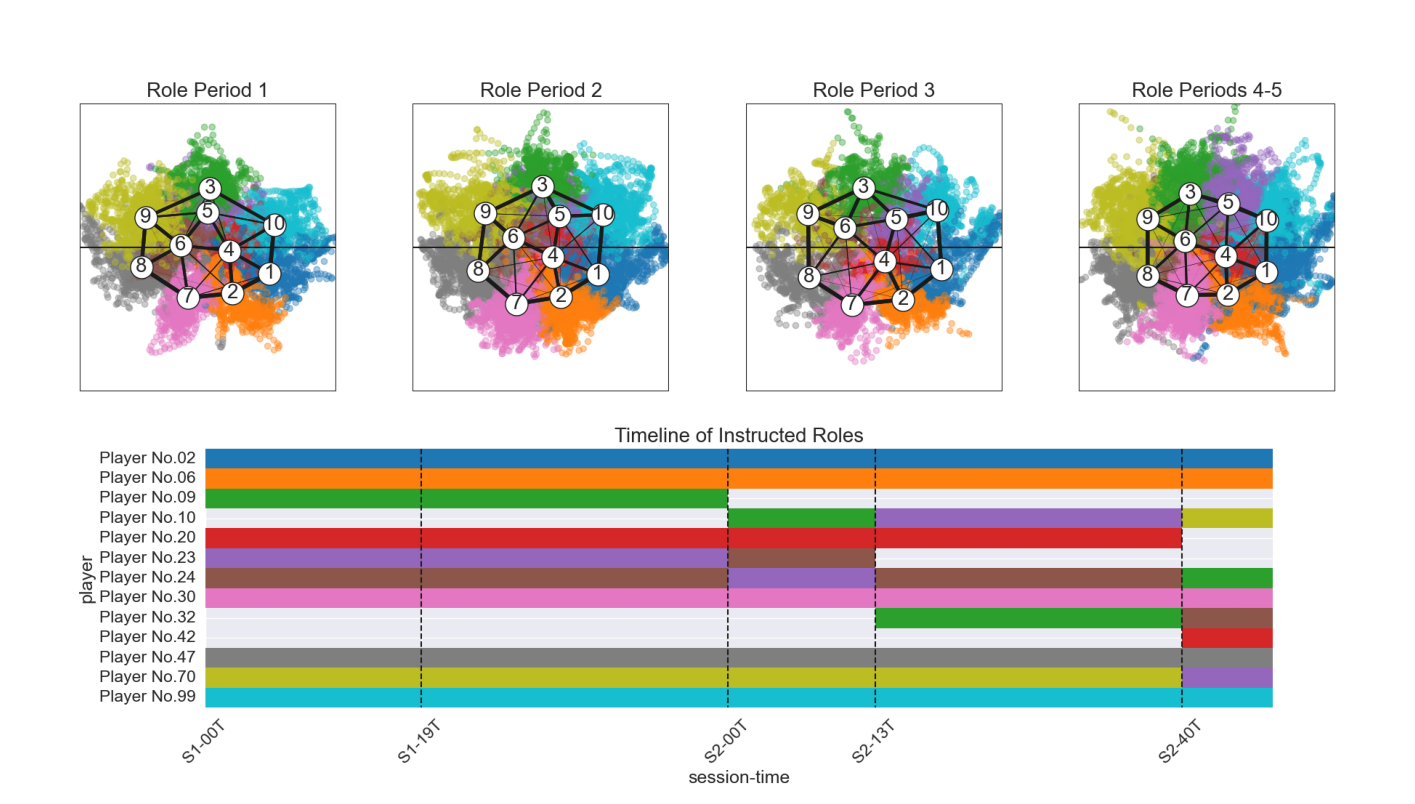

In [43]:
report_path = f'{DIR_DATA}/{cpd.formcpd_type}/report/{activity_id}.png'
img = mpimg.imread(report_path)
plt.figure(figsize=(18, 12))
plt.axis('off')
plt.imshow(img)
plt.show()

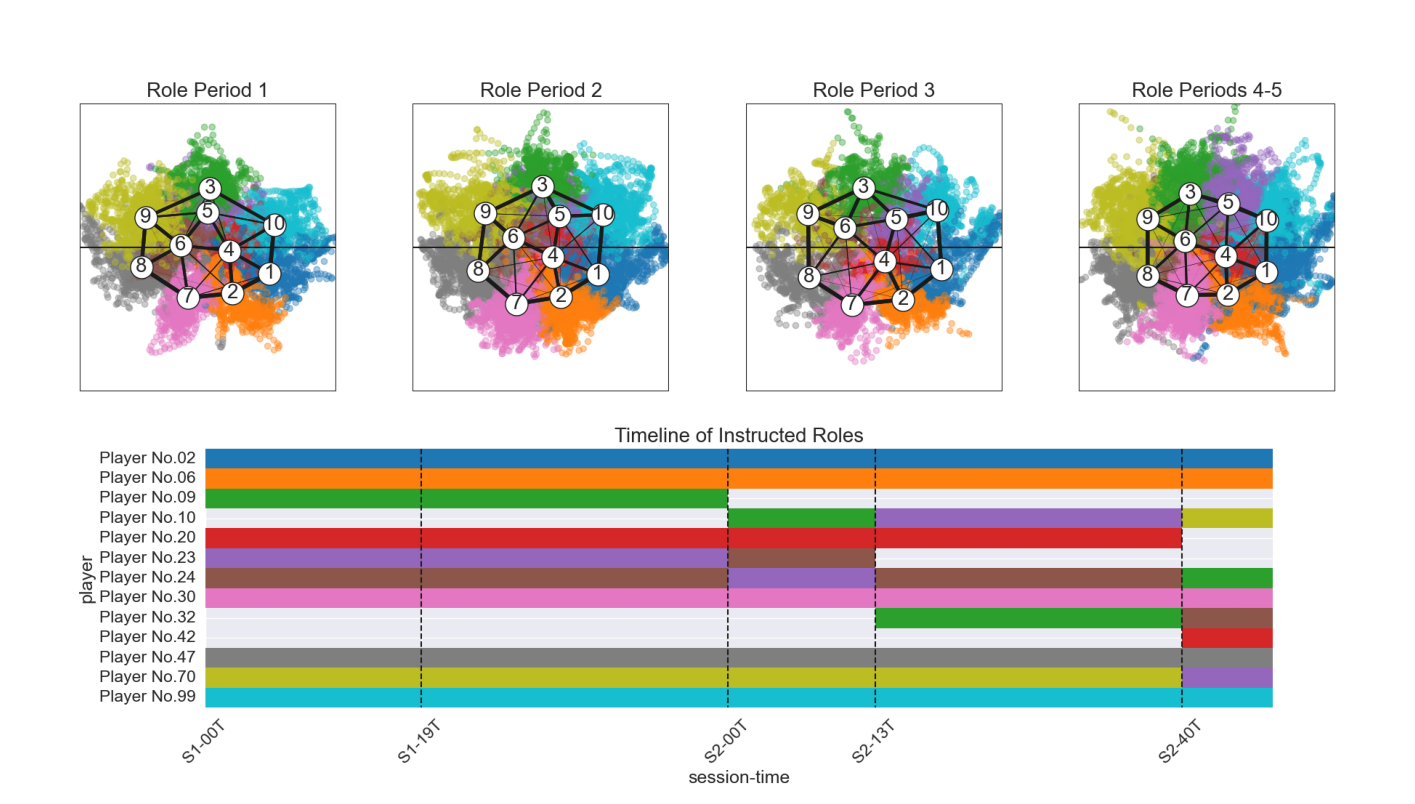

In [44]:
report_path = f'{DIR_DATA}/{cpd.formcpd_type}/report/{activity_id}.png'
img = mpimg.imread(report_path)
plt.figure(figsize=(18, 12))
plt.axis('off')
plt.imshow(img)
plt.show()

#### Experimenting with different hyperparameters values

In [45]:
MAX_SWITCH_RATE=0.1
MAX_PVAL = 0.01 # the p-value must be less than  0.01,
MIN_PERIOD_DUR = 300 # segments must last at least 5 minutes = 60*5=300 seconds
MIN_FORM_DIST = 7 #The Manhattan distance between segment means must exceed 7.0.

In [46]:
if os.path.exists('data\\gseg_avg\\fgp\\17985.csv'):
    os.remove('data\\gseg_avg\\fgp\\17985.csv')
cpd = SoccerCPD(match, formcpd_type='gseg_avg')
cpd.run()
cpd.visualize()
cpd.save_stats()


--------------------------------- Session 1 ----------------------------------
                 type session gametime            start_dt              end_dt
player_period                                                                 
1              START1       1    00~46 2020-01-01 19:00:00 2020-01-01 19:46:00

* Step 1: Frame-by-frame role assignment using RoleRep


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_fgp = self.ugp.groupby(LABEL_PLAYER_PERIOD).apply(RoleRep.generate_fgp, freq=freq)
C:\Users\Dell\

- Cost after iteration 1: 15.533


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.481


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 3: 15.473


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 4: 15.470
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying g-segmentation to the sequence between 19:00:01 and 19:46:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 1050 
  Test statistic: 1896.735 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 985 
  Test statistic: 8464.929 
  Approximated p-value: 0 
A significant fine-tuned change-point at 19:18:46.

Applying g-segmentation to the sequence between 19:00:01 and 19:18:46...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 936 
  Test statistic: 658.8085 
  Approximated p-value: 4.991125e-141 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 919 
  Test statistic: 558.4534 
  Approximated p-value: 2.880712e-119 
Change-point insignificant: One of the periods has not enough duration.

Applying g-segmentat

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fgp.groupby(LABEL_DATETIME, group_keys=False).apply(RoleRep.normalize_locs)
C:\Users\Dell\AppDat

- Cost after iteration 1: 15.561


C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  costs = fgp_cost_df.groupby(LABEL_DATETIME).apply(self.hungarian, self.role_distns).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\250369205.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_distns = fgp.groupby(cols).apply(RoleRep.estimate_mvn).reset_index()


- Cost after iteration 2: 15.602
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Applying g-segmentation to the sequence between 20:01:01 and 20:49:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 2268 
  Test statistic: 2106.951 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 758 
  Test statistic: 8047.47 
  Approximated p-value: 0 
Change-point insignificant: The formation is not changed.

Detected formation change-points (rounded off to the nearest 10 second mark):
[]

* Step 3: RoleCPD per formation period based on role permutations

RoleCPD for the formation period 3:
Applying g-segmentation to the sequence between 20:01:01 and 20:49:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 2324 
  Test statistic: 14819.25 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-p

C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:481: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.fgp = self.fgp.groupby(LABEL_DATETIME, group_keys=False).apply(SoccerCPD.recompute_switch_rate)



------------------------------------------------------------------------------
Formation Periods:
   form_period  session            start_dt              end_dt  duration
0            1        1 2020-01-01 19:00:00 2020-01-01 19:18:40    1120.0
1            2        1 2020-01-01 19:18:40 2020-01-01 19:46:00    1640.0
2            3        2 2020-01-01 20:01:00 2020-01-01 20:49:00    2880.0

Role Periods:
   form_period  role_period  session            start_dt              end_dt  duration
0            1            1        1 2020-01-01 19:00:00 2020-01-01 19:18:40    1120.0
1            2            2        1 2020-01-01 19:18:40 2020-01-01 19:46:00    1640.0
2            3            3        2 2020-01-01 20:01:00 2020-01-01 20:14:00     780.0
3            3            4        2 2020-01-01 20:14:00 2020-01-01 20:41:00    1620.0
4            3            5        2 2020-01-01 20:41:00 2020-01-01 20:49:00     480.0



C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", label="left")[[LABEL_SESSION, LABEL_GAMETIME, LABEL_BASE_ROLE]]
C:\Users\Dell\AppData\Local\Temp\ipykernel_18820\1880921021.py:581: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T", closed="right", 

'./data/gseg_avg/report/17985.png' saving done.
'./data/gseg_avg/fgp/17985.csv' saving done.
'./data/gseg_avg/form/17985.pkl' saving done.
'./data/gseg_avg/role/17985.csv' saving done.


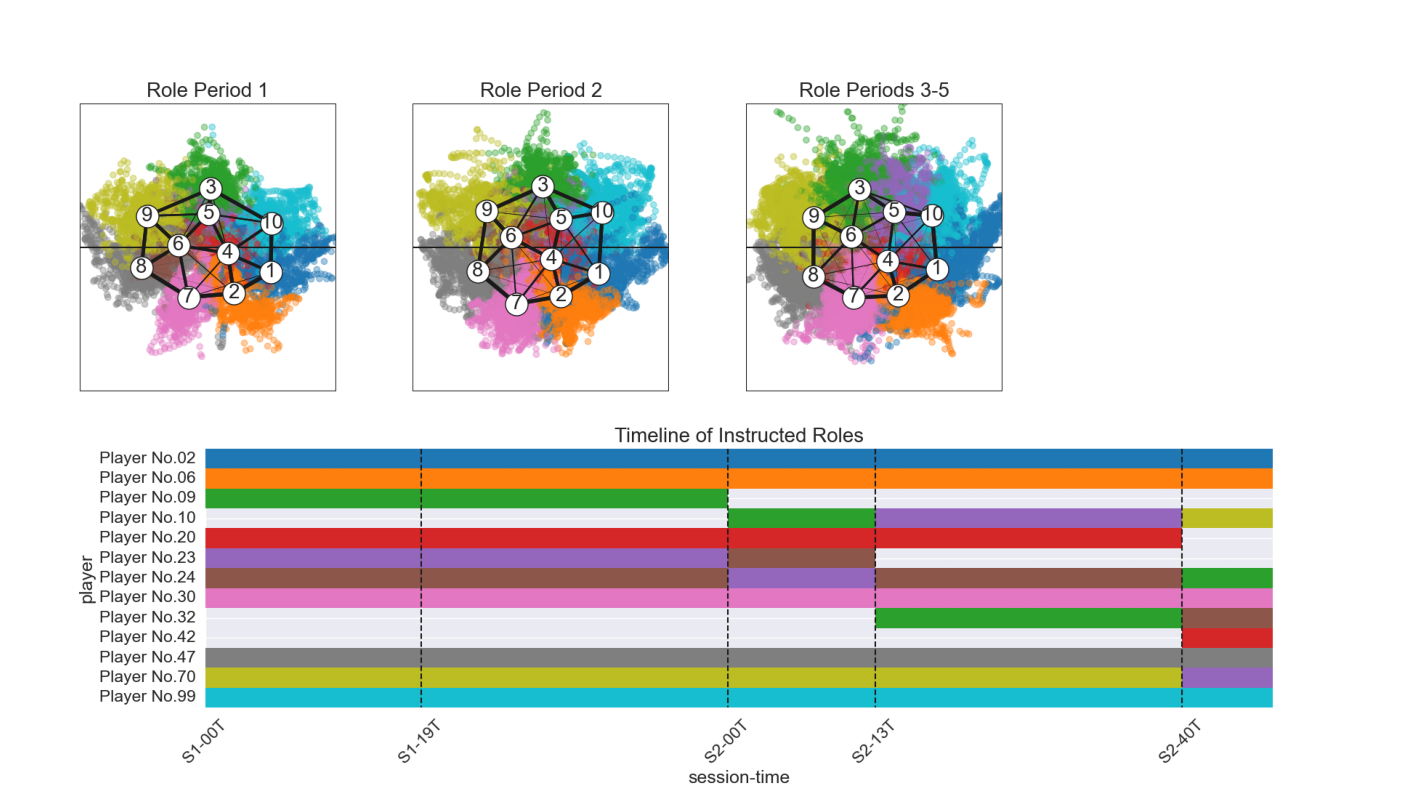

In [47]:
report_path = f'{DIR_DATA}/{cpd.formcpd_type}/report/{activity_id}.png'
img = mpimg.imread(report_path)
plt.figure(figsize=(18, 12))
plt.axis('off')
plt.imshow(img)
plt.show()

### Visualizing temporary Delaunay graphs
Fig. 2(a) in the paper

In [48]:
# FGP data (an abbreviation of "GPS data resulting from SoccerCPD")
activity_id = 17985
formcpd_type = 'gseg_avg'
fgp_path = f'{DIR_DATA}/{formcpd_type}/fgp/{activity_id}.csv'
fgp = pd.read_csv(fgp_path, sep=',', header=0)
fgp

datetime  player_id  session gametime  player_period  form_period  role_period       x       y  x_norm  y_norm  role  base_role  switch_rate  squad_num player_name
0      2020-01-01 19:00:01       1365        1  00:01.0              1            1            1  4223.0  5732.0  -503.7  2358.0     8          8          0.2         47         P47
1      2020-01-01 19:00:02       1365        1  00:02.0              1            1            1  4235.0  5822.0  -494.1  2450.5     8          8          0.0         47         P47
2      2020-01-01 19:00:03       1365        1  00:03.0              1            1            1  4233.0  5897.0  -531.3  2546.2     8          8          0.0         47         P47
3      2020-01-01 19:00:04       1365        1  00:04.0              1            1            1  4263.0  5936.0  -565.5  2567.3     8          8          0.0         47         P47
4      2020-01-01 19:00:05       1365        1  00:05.0              1            1            1  4279.0  5880.0  -619.1  2433.6     8          8          0.0         47         P47
...                    ...        ...      ...      ...            ...          ...          ...     ...     ...     ...     ...   ...        ...          ...        ...         ...
56352  2020-01-01 20:48:56       5608        2  47:56.0              4            3            5   800.0  3688.0  -772.9   348.9     7          7          0.5         30         P30
56353  2020-01-01 20:48:57       5608        2  47:57.0              4            3            5   806.0  3652.0  -629.4   371.3     7          7          0.5         30         P30
56354  2020-01-01 20:48:58       5608        2  47:58.0              4            3            5   860.0  3631.0  -526.1   453.2     7          7          0.5         30         P30
56355  2020-01-01 20:48:59       5608        2  47:59.0              4            3            5   769.0  3515.0  -618.1   384.7     7          7          0.5         30         P30
56356  2020-01-01 20:49:00       5608        2  48:00.0              4            3            5   710.0  3433.0  -718.9   301.8     7          7          0.4         30         P30

[56357 rows x 16 columns]

In [49]:
player_x = fgp.pivot_table(values='x', index='datetime', columns='player_name', aggfunc='first')
player_y = fgp.pivot_table(values='y', index='datetime', columns='player_name', aggfunc='first')
role_x = fgp.pivot_table(values='x', index='datetime', columns='role', aggfunc='first')
role_y = fgp.pivot_table(values='y', index='datetime', columns='role', aggfunc='first')
perms = fgp.pivot_table(values='role', index='datetime', columns='player_name', aggfunc='first')
perms

player_name          P02  P06  P09  P10  P20  P23  P24  P30  P32  P42  P47  P70   P99
datetime                                                                             
2020-01-01 19:00:01  1.0  2.0  5.0  NaN  4.0  3.0  6.0  7.0  NaN  NaN  8.0  9.0  10.0
2020-01-01 19:00:02  1.0  2.0  3.0  NaN  4.0  5.0  6.0  7.0  NaN  NaN  8.0  9.0  10.0
2020-01-01 19:00:03  1.0  2.0  3.0  NaN  4.0  5.0  6.0  7.0  NaN  NaN  8.0  9.0  10.0
2020-01-01 19:00:04  1.0  2.0  3.0  NaN  4.0  5.0  6.0  7.0  NaN  NaN  8.0  9.0  10.0
2020-01-01 19:00:05  1.0  2.0  3.0  NaN  4.0  5.0  6.0  7.0  NaN  NaN  8.0  9.0  10.0
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...
2020-01-01 20:48:56  1.0  4.0  NaN  3.0  NaN  NaN  6.0  7.0  9.0  2.0  8.0  5.0  10.0
2020-01-01 20:48:57  1.0  4.0  NaN  3.0  NaN  NaN  6.0  7.0  9.0  2.0  8.0  5.0  10.0
2020-01-01 20:48:58  1.0  4.0  NaN  3.0  NaN  NaN  6.0  7.0  9.0  2.0  8.0  5.0  10.0
2020-01-01 20:48:59  1.0  4.0  NaN  3.0  NaN  NaN  6.0  7.0  9.0  2.0  8.0  5.0  10.0
2020-01-01 20:49:00  1.0  3.0  NaN  6.0  NaN  NaN  2.0  7.0  9.0  4.0  8.0  5.0  10.0

[5640 rows x 13 columns]

In [50]:
# Set the starting index of the animation
idx = 400
fontsize = 20

players = player_x.columns
roles = np.sort(fgp['role'].unique())
colors = plt.cm.tab10(range(10))

xlim = 10800
ylim = 7200

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.set(xlim=(-500, xlim + 500), ylim=(-500, ylim + 500))
objs = []

def animate(t):
    ax.clear()
    # ax.set(xlim=(-500, xlim + 500), ylim=(-500, ylim + 500))
    ax.set(xlim=(0, xlim), ylim=(0, ylim))
    ax.vlines([0, xlim/2, xlim], ymin=0, ymax=ylim, color='k', zorder=0)
    ax.hlines([0, ylim], xmin=0, xmax=xlim, color='k', zorder=0)
    ax.axis('off')
    
    tri = Delaunay(np.vstack((role_x.iloc[idx+t], role_y.iloc[idx+t])).T)
    ax.scatter(tri.points[:, 0], tri.points[:, 1], s=750, c=roles, cmap='tab10', zorder=1)
    ax.triplot(tri.points[:, 0], tri.points[:, 1], tri.simplices,
               color='darkgrey', linewidth=3, zorder=0)
    
    for p in players:
        temp_x = player_x[p][max(0,idx+t-9):idx+t+1].values
        temp_y = player_y[p][max(0,idx+t-9):idx+t+1].values
        r = perms[p].iloc[idx+t]
        if not np.isnan(r):
            r = int(r)
            ax.plot(temp_x, temp_y, color=colors[r-1], linewidth=2)
            ax.annotate(r, xy=(role_x[r].iloc[idx+t], role_y[r].iloc[idx+t]),
                        ha='center', va='center', color='w', fontsize=fontsize, fontweight='bold', zorder=2)
            ax.annotate(p, xy=(role_x[r].iloc[idx+t], role_y[r].iloc[idx+t]-500), 
                        ha='center', va='center', color='k', fontsize=fontsize, zorder=2)

# To watch the snapshot, uncomment this code
animate(49)
plt.savefig(f'temp_mat.png', bbox_inches='tight')

# To watch the animation, uncomment this code
anim = animation.FuncAnimation(fig, animate, frames=100, interval=250)
plt.close(fig)
HTML(anim.to_jshtml())

# To save the animation, uncomment this code
anim.save('delaunay.gif', writer='pillow', fps=4)

### Visualizing the "mean" Delaunay graph
Fig. 2(b) in the paper

In [51]:
def delaunay_edge_mat(coords):
    tri_pts = Delaunay(coords).simplices
    edges = np.concatenate((tri_pts[:, :2], tri_pts[:, 1:], tri_pts[:, ::2]), axis=0)
    edge_mat = np.zeros((coords.shape[0], coords.shape[0]))
    edge_mat[edges[:, 0], edges[:, 1]] = 1
    return np.clip(edge_mat + edge_mat.T, 0, 1)

In [52]:
# Choose an activity and a formation period
activity_id = 17985
form_period = 1

formcpd_type = 'gseg_avg'
fgp_path = f'{DIR_DATA}/{formcpd_type}/fgp/{activity_id}.csv'
fgp = pd.read_csv(fgp_path, sep=',', header=0)

period_fgp = fgp[fgp['form_period'] == form_period]
period_role_x = period_fgp.pivot_table(values='x_norm', index='datetime', columns='role', aggfunc='first')
period_role_y = period_fgp.pivot_table(values='y_norm', index='datetime', columns='role', aggfunc='first')
period_role_coords = np.dstack([period_role_x.dropna().values, period_role_y.dropna().values])

period_edge_mats = []
for coords in period_role_coords:
    period_edge_mats.append(delaunay_edge_mat(coords))
period_edge_mats = np.stack(period_edge_mats, axis=0)

mean_role_coords = period_role_coords.mean(axis=0)
mean_edge_mat = period_edge_mats.mean(axis=0)

period_edge_mats, mean_edge_mat

(array([[[0., 1., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 1., ..., 1., 0., 0.],
         [1., 0., 1., ..., 0., 0., 0.]],
 
        [[0., 1., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 1., ..., 1., 0., 0.],
         [1., 0., 1., ..., 0., 0., 0.]],
 
        [[0., 1., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 1., ..., 1., 0., 0.],
         [1., 0., 1., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 1., 0., ..., 1., 0., 1.],
         [1., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 1., 1.],
         ...,
         [1., 0., 0., ..., 0., 1., 0.],
         [0., 0., 1., ..., 1., 0., 0.],


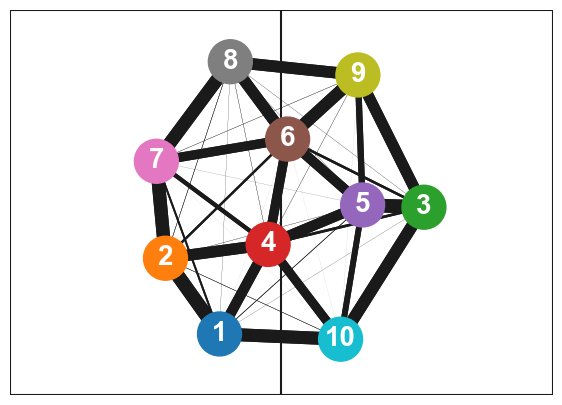

In [53]:
FormManager.visualize_single_graph(mean_role_coords, mean_edge_mat)
plt.savefig(f'mean_mat.png', bbox_inches='tight')